# PROJECT-2. Object Detection. 
## Детектирование медицинских масок

Основные задачи проекта:

   * Скачать и загрузить датасет;
   * Отрисовать один батч загруженных данных;
   * Выбрать предобученную модель и обосновать свой выбор в комментарии;
   * Обучить два детектора объектов, используя выбранную модель;
   * Визуализировать предсказания моделей;
   * Посчитать метрики IoU и mAP для каждой модели и построить графики Precision-Recall;
   * Описать полученные результаты в текстовой ячейке ноутбука.

Данные для обучения взяты на платформе [Kaggle](https://www.kaggle.com/andrewmvd/face-mask-detection).

In [2]:
# Импорт библиотек
# Для загрузки и анализа данных
import os
import glob
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
from tqdm import tqdm
from sklearn import preprocessing
from time import time
import shutil
import random

# Для работы с изображениями и построения моделей
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data.sampler import WeightedRandomSampler
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset
from PIL import Image, ImageDraw, ImageFont
from albumentations import (HorizontalFlip,
                            OneOf,
                            ISONoise,
                            ColorJitter,
                            Equalize,
                            FancyPCA,
                            AdvancedBlur,
                            ImageCompression,
                            RandomToneCurve,
                            RandomGamma,
                            RGBShift,
                            Compose)
import cv2
import shutil
from sklearn.model_selection import train_test_split
from torchmetrics.detection import MeanAveragePrecision
from ultralytics import YOLO

import matplotlib.pyplot as plt
from IPython.display import display

%matplotlib inline

## Загрузка и подготовка данных

In [3]:
# Зададим функцию для получения аннотаций из xml файлов. Сами данные уже скачаны, поэтому в функци по умолчанию 
# уже определен путь к локальной папке
def xml_to_csv(path = 'archive/annotations/',
               name='*.xml'):
    """Функция принимает путьк папке содержащей аннотации в формате .xml.
    Задает пустой список для сбора аннотаций из  xml-файлов. В цикле перебирает 
    xml-файлы. Для каждого файла в цикле перебираются все поля 'object' - объекты
    записанные в аннотации. Для каждого объекта извлеакется имя файла содержащего 
    данный объект, количество каналов, ширина и высота изображения, класс объекта 
    и координаты ограничивающей рамки. Извлеченные данные помещаются в кортеж который
    добавляются в заранее созданный список. После обработки всех файлов список 
    преобразуется в датафрейм, который и возвращает функция. 
    Args:
        path (str, optional): путь к папке с аннотациями, по умолчанию 'archive/annotations/'.
        name (str): имя файла, по умолчанию '*.xml'

    Returns:
        pd.DataFrame: Датафрейм с аннотациями для изображений. 
    """
    # Задаем список для сбора аннотаций
    xml_list = []
    
    # В цмкле перебираем все файлы с помощью модуля glob. glob.glob(pathname) возвращение список путей, 
    # соответствующих шаблону pathname.
    for xml_file in tqdm(glob.glob(path + name)):
        
        # Считываем файл и получаем его структуру 
        tree = ET.parse(xml_file)
        root = tree.getroot()
        
        # В цикле перебираем поля 'object'
        for obj in root.findall('object'):
            
            # В каждом находим поле 'bndbox' и извлекаем класс объекта и координаты 
            # ограничивающей рамки
            bbx = obj.find('bndbox')
            xmin = int(float(bbx.find('xmin').text))
            ymin = int(float(bbx.find('ymin').text))
            xmax = int(float(bbx.find('xmax').text))
            ymax = int(float(bbx.find('ymax').text))
            label = obj.find('name').text
            
            # Формируем кортеж содержащий аннотацию к текущему объекту: имя файла с 
            # изображением, количество каналов, ширина и высота изображения, класс объекта, 
            # координаты ограничивающей рамки 
            value = (root.find('filename').text,
                     int(root.find('size').find('depth').text),
                     int(root.find('size').find('width').text),
                     int(root.find('size').find('height').text),
                     label,
                     xmin,
                     ymin,
                     xmax,
                     ymax
                     )
            
            # Добавляем кортеж в список для сбора аннотаций
            xml_list.append(value)
            
    # Задаем список с именами колонок итогового датафрейма с аннотациями
    column_name = ['filename', 'channels', 'width', 'height',
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
    
    # Формируем и возвращаем итоговый датафрейм с аннотациями
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

In [4]:
# Создаем датафрейм с аннотациями, применив нашу функцию
xml_df = xml_to_csv()
print('Конвертация прошла успешно.')

100%|██████████| 853/853 [00:00<00:00, 7307.64it/s]

Конвертация прошла успешно.


In [5]:
# Выполним проверку на корректность аннотаций
print(len(xml_df[xml_df['ymax'] > xml_df['height']]))
print(len(xml_df[xml_df['ymax'] < xml_df['ymin']]))
print(len(xml_df[xml_df['xmax'] > xml_df['width']]))
print(len(xml_df[xml_df['xmax'] < xml_df['xmin']]))

# Для 12 объектов значение координаты xmax выходит за границы картинки.
display(xml_df[xml_df['xmax'] > xml_df['width']])

# Создадим список с наименованиями файлов аннотации которых содержат ошибку
err_ann = xml_df.loc[xml_df['xmax'] > xml_df['width'],'filename'].to_list()

0
0
12
0


filename  channels  width  height         class  xmin  ymin  \
107   maksssksksss231.png         3    400     249     with_mask   392    86   
140   maksssksksss787.png         3    400     288     with_mask   360    79   
823    maksssksksss93.png         3    400     267     with_mask   388    72   
1040  maksssksksss616.png         3    400     267     with_mask   394    92   
1624  maksssksksss251.png         3    400     206     with_mask   373    76   
1851  maksssksksss110.png         3    400     267  without_mask   381    14   
1907  maksssksksss706.png         3    400     267     with_mask   368   162   
2337    maksssksksss5.png         3    400     266  without_mask   364    30   
2749  maksssksksss603.png         3    400     278     with_mask   397   132   
2765  maksssksksss603.png         3    400     278  without_mask   396    18   
3190  maksssksksss457.png         3    400     300     with_mask   389    56   
3235  maksssksksss501.png         3    400     255     with_mask   357    65   

      xmax  ymax  
107    401   106  
140    401   139  
823    401    92  
1040   401   111  
1624   401   114  
1851   401    34  
1907   401   219  
2337   401    66  
2749   401   142  
2765   401    23  
3190   401    83  
3235   401   132

In [6]:
# Приравняем ошибочные координаты аннотаций к границе изображения
xml_df.loc[xml_df['xmax'] > xml_df['width'], 'xmax'] = 400

# Проверим отсутствие ошибок 
print(len(xml_df[xml_df['xmax'] > xml_df['width']]))

# Записываем датафрейм в csv-файл, на всякий случай
xml_df.to_csv('mask_df.csv', index=None)

0


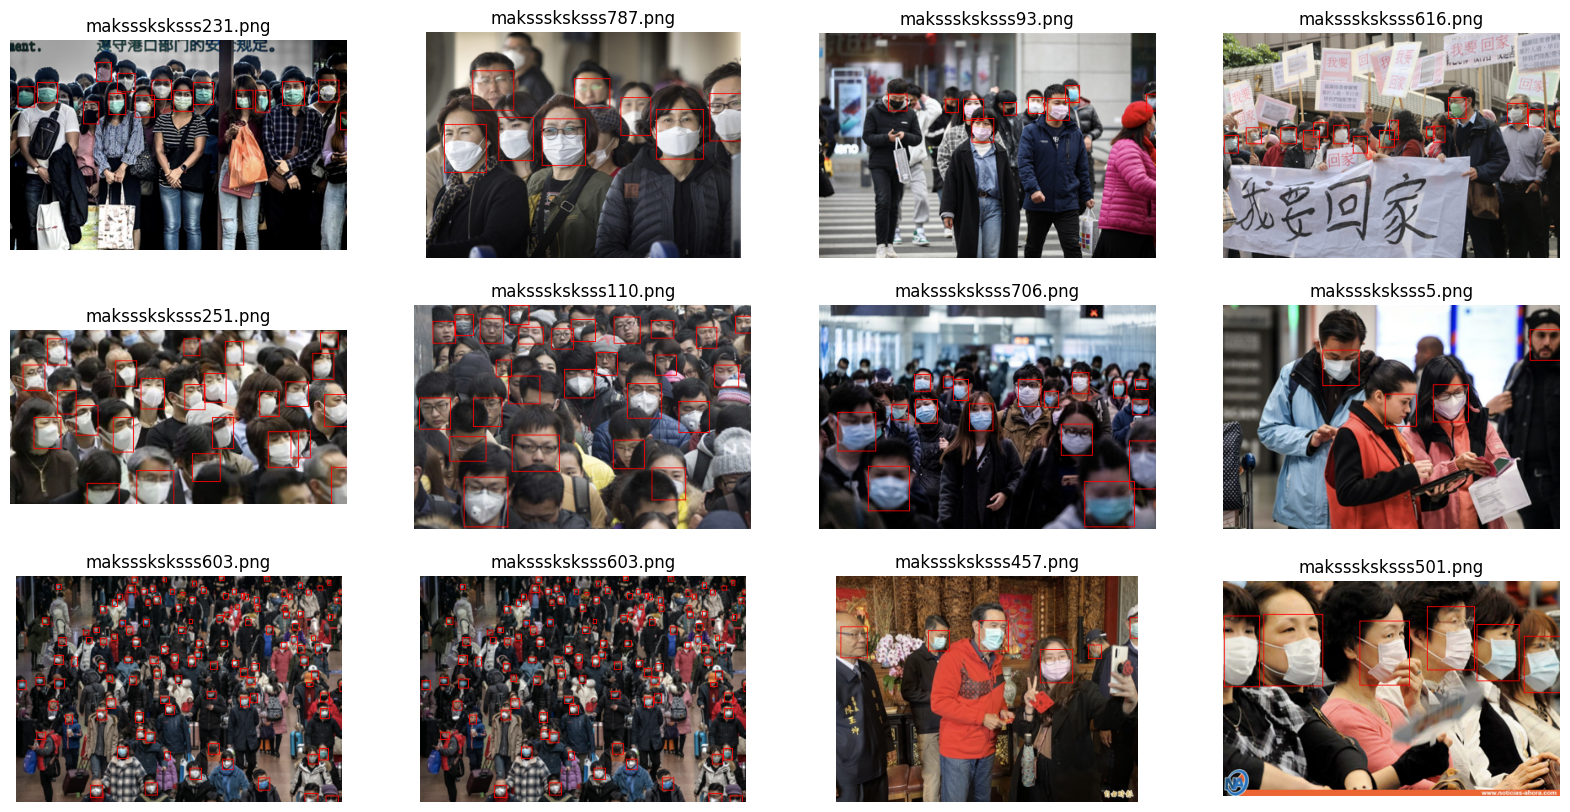

In [7]:
# Проверим как исправленные рамки выглядят на изображениях.
# Определяем полотно соответствующее количеству изображений в батче    
fig, axes = plt.subplots(3, 4, figsize=(20, 10))

# Задаем цикл по ячейкам созданного полотна, метод .ravel() преобразует матрицу 3х4 в вектор
for i, ax in enumerate(axes.ravel()):
   
    # Задаем путь к изображению из тестовой выборки
    img_path = f'archive/images/{err_ann[i]}'    
    
    # Загружаем изображение, преобразуем в RGB и переводим в смежные ячейки памяти
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.ascontiguousarray(image) 

    
    # получаем координаты для всех ограничительных рамок текущего изображения
    bbox = xml_df[xml_df['filename']==err_ann[i]].to_numpy()

    # В цикле перебираем все аннотации
    for box in bbox:
        
        # Получаем параметры текущей аннотации
        x0, y0, x1, y1 = box[-4:]
        
        # Отрисовываем ограничительную рамку на текущем изображении
        cv2.rectangle(image,
                      (int(x0), int(y0)),
                      (int(x1), int(y1)),
                      color=(255,0,0),
                      thickness=1
                      )
    
    # Выводим изображение и его наименование                
    ax.imshow(image)
    ax.set_title(err_ann[i])
  
    # отключаем отображение осей
    ax.axis("off")
plt.show()

In [8]:
# Используем класс LabelEncoder библиотеки sklearn для кодирования меток классов
le = preprocessing.LabelEncoder()
xml_df['label'] = le.fit_transform(xml_df['class'])

In [9]:
# Проверяем результат кодировки
xml_df.head()

filename  channels  width  height         class  xmin  ymin  \
0   maksssksksss45.png         3    400     226  without_mask    63    34   
1   maksssksksss45.png         3    400     226     with_mask   222    40   
2   maksssksksss45.png         3    400     226  without_mask   250   159   
3  maksssksksss278.png         3    400     300     with_mask   295    75   
4  maksssksksss278.png         3    400     300     with_mask   198    91   

   xmax  ymax  label  
0    95    63      2  
1   272    84      1  
2   279   203      2  
3   334   115      1  
4   223   116      1

In [10]:
# Создадим словарь с ключами - порядковыми номерами классов и 
# значениями - метками классов
class_id_to_name_mapping = dict(zip(range(len(le.classes_)), le.classes_))

## Разбиение данных на тренировочную и валидационную выборки

In [11]:
# Посмотрим на распределение преобладающих меток классов объектов на изображениях.
# Получим массив уникальных имен файлов изображений
uniq = xml_df['filename'].unique()

# Сгруппируем данные по имени файла изображения и метке класса объекта на 
# изображении и определим количество и класс объектов для каждого изображения
tab = xml_df.groupby(['filename','label'], as_index=False)['xmin'].count()

# Создадим пустой список для сбора преобладающих меток классов объектов на 
# каждом изображении
major_class = []

# В цикле перебираем каждое наименование файла изображения
for name in uniq:
    
    # Определяем максимальное количество объектов класса для текущего имени файла
    max_obj = tab[tab['filename']==name]['xmin'].max()
    
    # И принимаем для данного изображения этот класс.
    # Возможен случай когда на изображении присутствует одинаковое количество объектов 
    # различных классов, поэтому фильтруем нашу таблицу по текущему имени и максмиальному 
    # количеству объектов класса на текущем изображении. Результат преобразуем в список и 
    # добавляем к списку преобладающих классов
    major_class.append(list(tab[(tab['filename']==name) & (tab['xmin']==max_obj)]['label'].values))
    

In [12]:
# Создадим словарь где ключами будут метки классов, а значениями количество 
# изображений на которых этот класс объектов был преобладающим
dict_class = {}

# При заполнении словаря будем учитывать те изображения, где преобладающий класс объектов 
# всего один.В цикле перебираем список преобладающих классов, если длина текущего элемента
# списка преобладающих классов равна единице пробуем увеличить значение словаря по этой метке
# класса (ключу) на единицу. Если записи с таким ключом в словаре еще нет создаем её присвоив 
# значение один
for i in major_class:
    if len(i) == 1:
        try:
            dict_class[i[0]]+=1
        except:
            dict_class[i[0]]=1

# Все метки классов попали в словарь, значит для каждого класса в нашем наборе
# данных есть изображение, где он является преобладающим
print(sorted(dict_class.keys()))


[np.int64(0), np.int64(1), np.int64(2)]


In [13]:
# Теперь обработаем изображения на которых есть одинаковое количество преобладающих объектов.
# Создадим список для сбора преобладающей на изображении метки класса
ls_class = []

# В цикле перебираем значения списка преобладающих классов major_class (в данном списке значения
# соответствуют списку уникальных имен файлов изображений, т.е. по сути мы перебираем метки классов
# преобладающих на каждом изображении в наборе данных)
for i in major_class:
    
    # Если преобладающий класс на изображении один - вносим его метку в список
    if len(i) == 1:
        ls_class.append(i[0])
        
    # Если таких классов несколько - будем сверяться со словарем преобладающих классов    
    else:
        
        # Создадим вспомагательный список для хранения количества изображений, на которых
        # преобладают интересующие нас классы
        maj_class = []
        
        # В цикле перебираем метки классов равноценно представленных на текущем изображении
        for j in i:
            
            # В вспомогательный список заносим количество изображений для текущей метки 
            # класса из созданного ранее словаря
            maj_class.append(dict_class[j])
            
        # Чтобы уменьшить дисбаланс классов будем для спорных изображений выбирать метку преобладающего 
        # класса с минимальным значением       
        major = i[maj_class.index(min(maj_class))] 
        
        # Вносим метку класса в список и обновляем значения для метки этого класса в словаре
        ls_class.append(major)
        dict_class[major]+=1
            

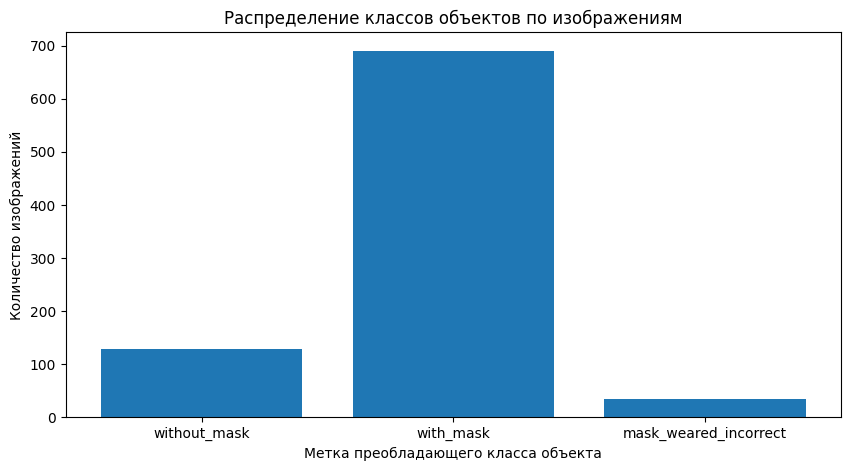

In [14]:
# Визуализируем результат. Определяем значения для оси Х 
x = range(len(dict_class.values()))

# Создаем фигуру
plt.figure(figsize=(10, 5))

# Рисуем столбчатую диаграмму
plt.bar(x, # по оси Х - порядковые номера значений из солваря
        dict_class.values() # по оси У - значения словаря   
        )

# Задаем метки оси Х. В качестве имен меток используем ключи словаря
plt.xticks(ticks=x,
           labels= [class_id_to_name_mapping[i] for i in dict_class.keys()]
           )

# Настраиваем наименование графика и осей
plt.xlabel('Метка преобладающего класса объекта')
plt.ylabel('Количество изображений')
plt.title('Распределение классов объектов по изображениям')

# Выводим изображение
%matplotlib inline
plt.show()

# Закрываем окно с графиком, а также освобождаем ресурсы памяти
plt.close()

In [15]:
# Полученный список уникальных наименований файлов изображений и список преобладающих 
# на этих изображениях классов преобразуем в датасет, который будем использовать для 
# стратифицированного разбиения выборки на тренировочный и валидационный наборы данных
df = pd.DataFrame({'filename':uniq,
                   'class':ls_class})

# Получаем перечень имен файлов для тренировочной (80%) и валидационной выборки (20%)
# применив стратифицированное разбиение по меткам преобладающего на изображениях класса 
train_name, val_name = train_test_split(df,
                                        shuffle=True,
                                        random_state=42,
                                        train_size=0.8,
                                        stratify=df['class']
                                        )


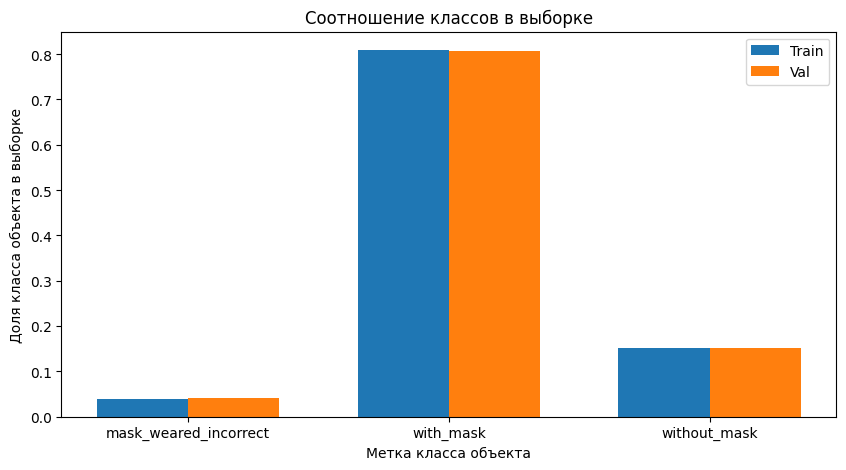

In [16]:
# Подготовим данные для визуализации распределения классов по выборкам. 
# Для этого группируем перечни имен файлов с изображениями по меткам преобладающих 
# на них классов и переименовывам колонку с именами файлов, добавляя префикс 
# соответствующий текущей выборке
df_train = train_name.groupby(['class'], as_index=False).count()
df_train = df_train.rename(columns={'filename':'train_filename','class':'class'})
df_val = val_name.groupby(['class'], as_index=False).count()
df_val = df_val.rename(columns={'filename':'val_filename','class':'class'})

# Объединяем полученные таблицы в вспомогательный датасет по меткам преобладающих классов
sub_df = pd.merge(df_train, df_val, on='class')

# Вычисляем долю меток классов в каждой выборке
sub_df['train_filename'] = sub_df['train_filename'].apply(lambda x: x/sub_df['train_filename'].sum())
sub_df['val_filename'] = sub_df['val_filename'].apply(lambda x: x/sub_df['val_filename'].sum())

# Визуализируем результат. Задаем вспомагательные переменные - в качестве значений оси Х используем 
# метки преобладающих классов и ширину столбца столбчатой диаграммы
x = sub_df['class'].values 
width = 0.35

# Создаем фигуру и рисуем столбчатые диаграммы для кадлой выборки. Испоьзуем заданную ранее ширину 
# столбца для смещения столбцов на диаграмме по сои Х
fig, ax = plt.subplots(figsize=(10,5))
rects1 = ax.bar(x - width/2, sub_df['train_filename'], width, label='Train')
rects2 = ax.bar(x + width/2, sub_df['val_filename'], width, label='Val')

# Настраиваем отображение
ax.set_ylabel('Доля класса объекта в выборке')
ax.set_xlabel('Метка класса объекта')
ax.set_xticks(ticks=x,
              labels= [class_id_to_name_mapping[i] for i in x]
              )
ax.legend()
ax.set_title('Соотношение классов в выборке');


In [17]:
# Формируем датафреймы используя сделанное ранее разбиение данных для тренировочной и
# валидационной выборок
train_df = xml_df[xml_df['filename'].isin(train_name['filename'].values)]
val_df = xml_df[xml_df['filename'].isin(val_name['filename'].values)]

# Подготовка данных для модели YOLO






In [18]:
# Формируем структуру папок, чтобы подготовить набор данных для модели YOLO
for  i in ['train', 'val']:          
    im = 'data/images/' + i
    ann = 'data/labels/' + i
    
    # Пробуем удалить всю директорию и создать её заново, 
    # если её не было - создаем
    try:
        shutil.rmtree(im)
        os.makedirs(im)
    except:
        os.makedirs(im)
    try:
        shutil.rmtree(ann)
        os.makedirs(ann)
    except:
        os.makedirs(ann)

In [19]:
# Определим функцию для преобразования аннотаций добавив в качестве 
# аргумента путь для сохранения аннотаций
def convert_to_yolov5(df, unique_img_names, path):
    """Функция принимает датафрейм с аннотациями и перечень уникальных
    имен файлов с изображениями. Для каждого уникального имени находит 
    все аннотации в датафрейме. Преобразует их в формат YOLO (`Class, 
    X, Y, Width, Height`) и нормализует. После нахождения всех объектов
    формирует текстовый файл с аннотациями по пути переданному в аргументе
    path. Процесс повторяется для всех уникальных имен файлов с изображениями
    из полученного перечня.

    Args:
        df (pd.DataFrame): датафрейм с аннотациями в формате ['filename',
        'channels', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 
        'ymax', 'label']
        unique_img_names (numpy.ndarray): массив с уникальными именами файлов
        с изображениями
        path (str): путь к папке для сохранения файла аннотаций.
    """
    
    # преобразуем полученный датафрейм в массив списков 
    # для перебора в цикле 
    df_array = np.array(df)
    
    # Для каждого уникального изображения
    for unique_img_name in unique_img_names:
        
        # Создаем переменную буфер
        print_buffer = []

        # Перебираем в цикле индексы всех объектов из полученного датафрейма
        for i in range(len(df)):            
        
            # получаем текущий элемент массива
            point =  df_array[i]
        
            # извлекаем имя файла аннотации - первая колонка датафрейма
            img_name = point[0]

            # если имя файла аннотации соответствует текущему уникальному 
            # имени изображения
            if img_name == unique_img_name:
                
                # записываем метку класса объекта - пятая колонка датафрейма
                class_id = point[9]
      
                # Преобразуем координаты bbox. Здесь point[5] - xmin, point[6] - ymin, 
                # point[7] - xmax, point[8] - ymax. Вычисляем координаты центра ограничительной 
                # рамки
                X = (point[5] + point[7]) / 2 
                Y = (point[6] + point[8]) / 2 
                
                # Вычисляем ширину и высоту ограничительной рамки
                Width = (point[7] - point[5])
                Height = (point[8] - point[6])
              
                # Нормализуем координаты, разделив полученные значения на ширину и длину изображения
                image_c, image_w, image_h = point[1], point[2], point[3] 
                X /= image_w 
                Y /= image_h 
                Width /= image_w 
                Height /= image_h 
              
                # Запишем информацию о bbox в файл
                print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, X, Y, Width, Height))  
                
        # Дадим имя файлам, которые хотим сохранить. В качестве пути сохранения 
        # используем переданный в аргументах путь
        save_file_name = os.path.join(path, unique_img_name.replace("png", "txt"))
        
        # Объединяем элементы списка в строку используя в качестве разделителя символ 
        # переноса коретки "\n" и сохраняем результат вывода аннотации в файл на диск
        print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [20]:
# Получим аннотации в новом формате для каждой выборки
convert_to_yolov5(df=train_df,
                  unique_img_names=train_df['filename'].unique(),
                  path='data/labels/train'
                  )
convert_to_yolov5(df=val_df,
                  unique_img_names=val_df['filename'].unique(),
                  path='data/labels/val'
                  )

In [21]:
# Задаем путь к исходной папке, где хранятся все изображения
path_s = r'archive/images/'

# Задаем путь к целевой папке, где будут хранится изображения каждой выборки
path_d = r'data/images/'

# В цикле перебираем наименование всех изображений в выборке и копируем 
# файл изображения в соответствующую целевую папку
for file in train_df['filename'].unique():
    shutil.copyfile(path_s+file, path_d+'train/'+file)
    
for file in val_df['filename'].unique():
    shutil.copyfile(path_s+file, path_d+'val/'+file)

In [22]:
# Проверяем что все изображения имеют аннотации
counter_t = []
for name in os.listdir('data/images/train/'):
    if name.replace('png', 'txt') not in os.listdir('data/labels/train/'):
        counter_t.append(name)
print(f'Количество изображений без аннотаций в обучающей выборке: {len(counter_t)}')
    
counter_v = []
for name in os.listdir('data/images/val/'):
    if name.replace('png', 'txt') not in os.listdir('data/labels/val/'):
        counter_v.append(name)
print(f'Количество изображений без аннотаций в валидационной выборке: {len(counter_v)}')        

Количество изображений без аннотаций в обучающей выборке: 0
Количество изображений без аннотаций в валидационной выборке: 0


In [23]:
# Выполняем проверку на дублирование изображений в папках train и val
ls=[]
for name in os.listdir('data/images/train/'):
    if name in os.listdir('data/images/val/'):
        ls.append(name)

print(f'Количество изображений пристуствующих в обеих выборках: {len(ls)}')

Количество изображений пристуствующих в обеих выборках: 0


# Подготовка данных для модели FRCNN





In [24]:
# Определим вспомогательную функцию для получения списка аугментаций изображений
def get_transforms(phase):
    """Функция принимает на вход строку с текущим флагом выборки.
    Если флаг соответствует 'train', функция возвращает пайплайн 
    аугментаций изображения для тренировочной выборки. Если нет 
    в пайплайн включается только преобразование изображения в тензор
    Args:
        phase (str): флаг выборки

    Returns:
        Compose: пайплайн аугментаций изображения
    """
    # Задаем пустой список для сбора аугментаций    
    list_transforms = []
    
    # Проверяем передан ли флаг тренировочной выборки
    if phase == 'train':
        
        # Для тренировочной выборки определяем аугментации поворота изображения,
        # добавления шумов, изменнеие цветов, гаммы ит.п.
        list_transforms.extend([HorizontalFlip(p=1),
                                OneOf([ISONoise(),
                                       ColorJitter(hue=0.1),
                                       Equalize(by_channels=False),
                                       FancyPCA(),
                                       AdvancedBlur(p=0.1),
                                       ImageCompression(),
                                       RandomToneCurve(),
                                       RandomGamma(),                                          
                                       RGBShift(r_shift_limit=0.1,
                                                g_shift_limit=0.1,
                                                b_shift_limit=0.1
                                                )
                                       ]
                                      )
                                ]
                               )

    # Добавляем преобразование изображения в тензор            
    list_transforms.extend([ToTensorV2()])

    # Создаем пайплайн аугментаций            
    list_trfms = Compose(list_transforms,
                         bbox_params={'format': 'pascal_voc', # формат ограничивающих рамок
                                      'label_fields': ['labels']  # список полей, которые соединены с ограничительными рамками
                                      }                         
                         )
    
    # Возвращаем полученный пайплайн аугментаций
    return list_trfms

In [25]:
# Создаем кастомный класс для формирования датасета
class VOC_2010(Dataset):
      
    # Функция инициализации
    def __init__(self, df, image_dir, phase='train'):
        
        # Вызываем метод инициализации из родительского класса
        super().__init__()
        
        # Дополняем наши данные
        self.df = df
        self.image_dir = image_dir
        self.images = df['filename'].unique()
        self.transforms = get_transforms(phase)
        
    # Задаем функцию для определения количества изображений 
    # в датасете
    def __len__(self):
        return len(self.images)
    
    # Определяем функцию для получения экземпляра из датасета по индексу
    def __getitem__(self,idx):
        
        # Получаем имя файла изображения
        image = self.images[idx]

        # Отбрасываем расширение файла
        image_id = str(image.split('.')[0])
        
        # Считываем файл изображения
        image_arr = cv2.imread(os.path.join(self.image_dir,image), cv2.IMREAD_COLOR)
        
        # Преобразуем порядок каналов в RGB        
        image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB).astype(np.float32)

        # Нормализация данных
        image_arr /= 255.0
        
        # Получаем строку датасета для текущего изображения
        point = self.df[self.df['filename'] == image]
        
        # Записываем в переменную координаты ограничительной рамки
        boxes = point[['xmin', 'ymin', 'xmax', 'ymax']].values
        
        # Вычисляем площадь внутри ограничительной рамки
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        
        # Запишем класс объекта в переменную label
        labels = torch.as_tensor(point['label'].values, dtype=torch.int64)
        
        # Формируем словарь с аннотациями
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor(idx)
        target['area'] = area
        
        # Применяем аугментации
        if self.transforms:
            sample = {'image': image_arr,
                      'bboxes': target['boxes'],
                      # Здесь пришлось добавить преобразование тензора в список, потому 
                      # что при итерации по тензору он возвращает тензор с одним числом, 
                      # но получить метку класса используя тензор в качестве ключа не получится
                      'labels': target['labels'].tolist()
                      }
            sample = self.transforms(**sample)
            image = sample['image']
        
        # Переопределяем координаты ограничительных рамок после аугментации изображений 
        target['boxes'] = torch.stack(tuple(map(torch.tensor, 
                                                zip(*sample['bboxes'])))).permute(1, 0)
        
        # Возвращаем кортеж из изображения, словаря с аннотациями и имени файла 
        return image, target, image_id
            

In [26]:
# Копируем выборки
frcnn_train_df = train_df.copy()
frcnn_val_df = val_df.copy()

# Получаем словарь весов преобладающих классов как обратную величину вероятности
# преобладающего класса, чтобы самый редкий класс имел наибольший вес
im_weight = df['class'].value_counts(normalize=True)
im_weight = im_weight.apply(lambda x: 1 - x).to_dict()

# Создаем признак веса изображения по преобладающему классу
df['img_weight'] = df['class'].apply(lambda x: im_weight[x])

# Получаем словарь весов изображений по преобладающему классу
img_weight = dict(zip(df['filename'], df['img_weight']))

# Добавляем веса изображений в наши выборки
frcnn_train_df['img_weight'] = frcnn_train_df['filename'].apply(lambda x: img_weight[x])
frcnn_val_df['img_weight'] = frcnn_val_df['filename'].apply(lambda x: img_weight[x])

В [документации](https://docs.pytorch.org/tutorials/intermediate/torchvision_tutorial.html) указано, что метка 0 зарезервирована для фонового класса:
 - labels, integer torch.Tensor of shape [N]: the label for each bounding box. 0 represents always the background class.

In [27]:
# Переопределим метки классов
labels_dict = dict(zip(range(1, len(le.classes_) + 1), le.classes_))

frcnn_train_df['label'] = train_df['label']+1
frcnn_val_df['label'] = val_df['label']+1

In [28]:
# Определяем путь к директории с изображениями
image_dir = 'archive/images'

# Формируем тренировочный и валидационный датасеты с помощью определенного выше класса
train_data = VOC_2010(frcnn_train_df, image_dir, phase='train')
val_data = VOC_2010(frcnn_val_df, image_dir, phase='validation')

# Проверяем размер полученных датасетов
print(f'Размер обучающей выборки {len(train_data)}')
print(f'Размер валидационной выборки {len(val_data)}')

Размер обучающей выборки 682
Размер валидационной выборки 171


/home/tio/CV/CV_git/Projects/Project_CV_2/project2_env/lib/python3.10/site-packages/albumentations/core/composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


In [29]:
# Определяем размер батча и функцию, определяющую порядок формирования батча
batch = 2
def collate_fn(batch):
    return tuple(zip(*batch))

# Получаем тензоры с весами изображений. Он должен содержать весовое значение для каждого изображения
img_weight_train = torch.as_tensor(np.array(frcnn_train_df.drop_duplicates(subset='filename')['img_weight']),
                                   dtype=torch.float16
                                   )

# Создаем объект sampler для борьбы с дисбалансом классов
train_sampler = WeightedRandomSampler(weights=img_weight_train,
                                      num_samples=len(img_weight_train),
                                      replacement=True
                                      )

# Формируем объекты класса DataLoader для полученных датасетов
train_data_loader = DataLoader(train_data,
                              batch_size=batch,
                              shuffle=False,
                              sampler=train_sampler,
                              collate_fn=collate_fn
                              )

val_data_loader = DataLoader(val_data,
                             batch_size=batch,
                             shuffle=False,
                             collate_fn=collate_fn
                             )

In [30]:
# Определим функцию для визуализации батча изображений
def vis_batch(dataloader):
    """Функция принимает на вход объект DataLoader. Определяет количество 
    батчей и случайный образом выбирает один из них. Визуализирует изображения 
    из выбранного батча с ограничительными рамками и метками классов из 
    аннотации к текущему изображению.

    Args:
        dataloader (torch.utils.data.DataLoader): объект даталоадер
    """
    
    # Определяем количество батчей в даталоадере
    batch_count = dataloader.__len__()
    
    # Случайным образом выбираем номер батча
    ind = random.choice(range(batch_count))
  
    # Создаем итератор на основе полученного даталоадера
    batch_iter = iter(dataloader)

    # Перебираем итератор в цикле    
    for idx, (images, target, names)  in enumerate(batch_iter):
        
        # Когда номер батча совпадает с выбранным
        if idx == ind:
            
            # Выводим номер батча
            print("Номер батча: ", ind)
            
            # Определяем полотно соответствующее количеству изображений в батче    
            fig, axes = plt.subplots(1, len(images), figsize=(30, 15))
            
            # Задаем цикл соответствующей количеству изображений в батче
            for j, image in enumerate(images):
                
                # подготавливаем изображение
                image = image.clone().cpu().numpy()
                image = image.transpose((1,2,0))
                image = (image * 255).astype(np.uint8)                
                image = np.ascontiguousarray(image)
                
                # получаем координаты для всех ограничительных рамок текущего изображения
                bbox = target[j]['boxes'].numpy()
                
                # В цикле перебираем каждую ограничительную рамку и отображаем ее на изображении
                for i, box in enumerate(bbox):
                    cv2.rectangle(image,
                                  (int(box[0]),int(box[1])),
                                  (int(box[2]),int(box[3])),
                                  (255,0,0),
                                  thickness=1
                                  )
                    
                    # Выводим класс объекта
                    cv2.putText(image,
                                f'{labels_dict[target[j]["labels"][i].item()]}',
                                (int(box[0]),int(box[1])), # расположение
                                cv2.FONT_HERSHEY_SIMPLEX, # шрифт
                                0.5, # размер шрифта
                                (255,0,0), # цвет
                                1 # толщина
                                )
               
                # Выводим изображение                
                axes[j].imshow(image)
                 
                # отключаем отображение осей
                axes[j].axis("off")
                

Номер батча:  36


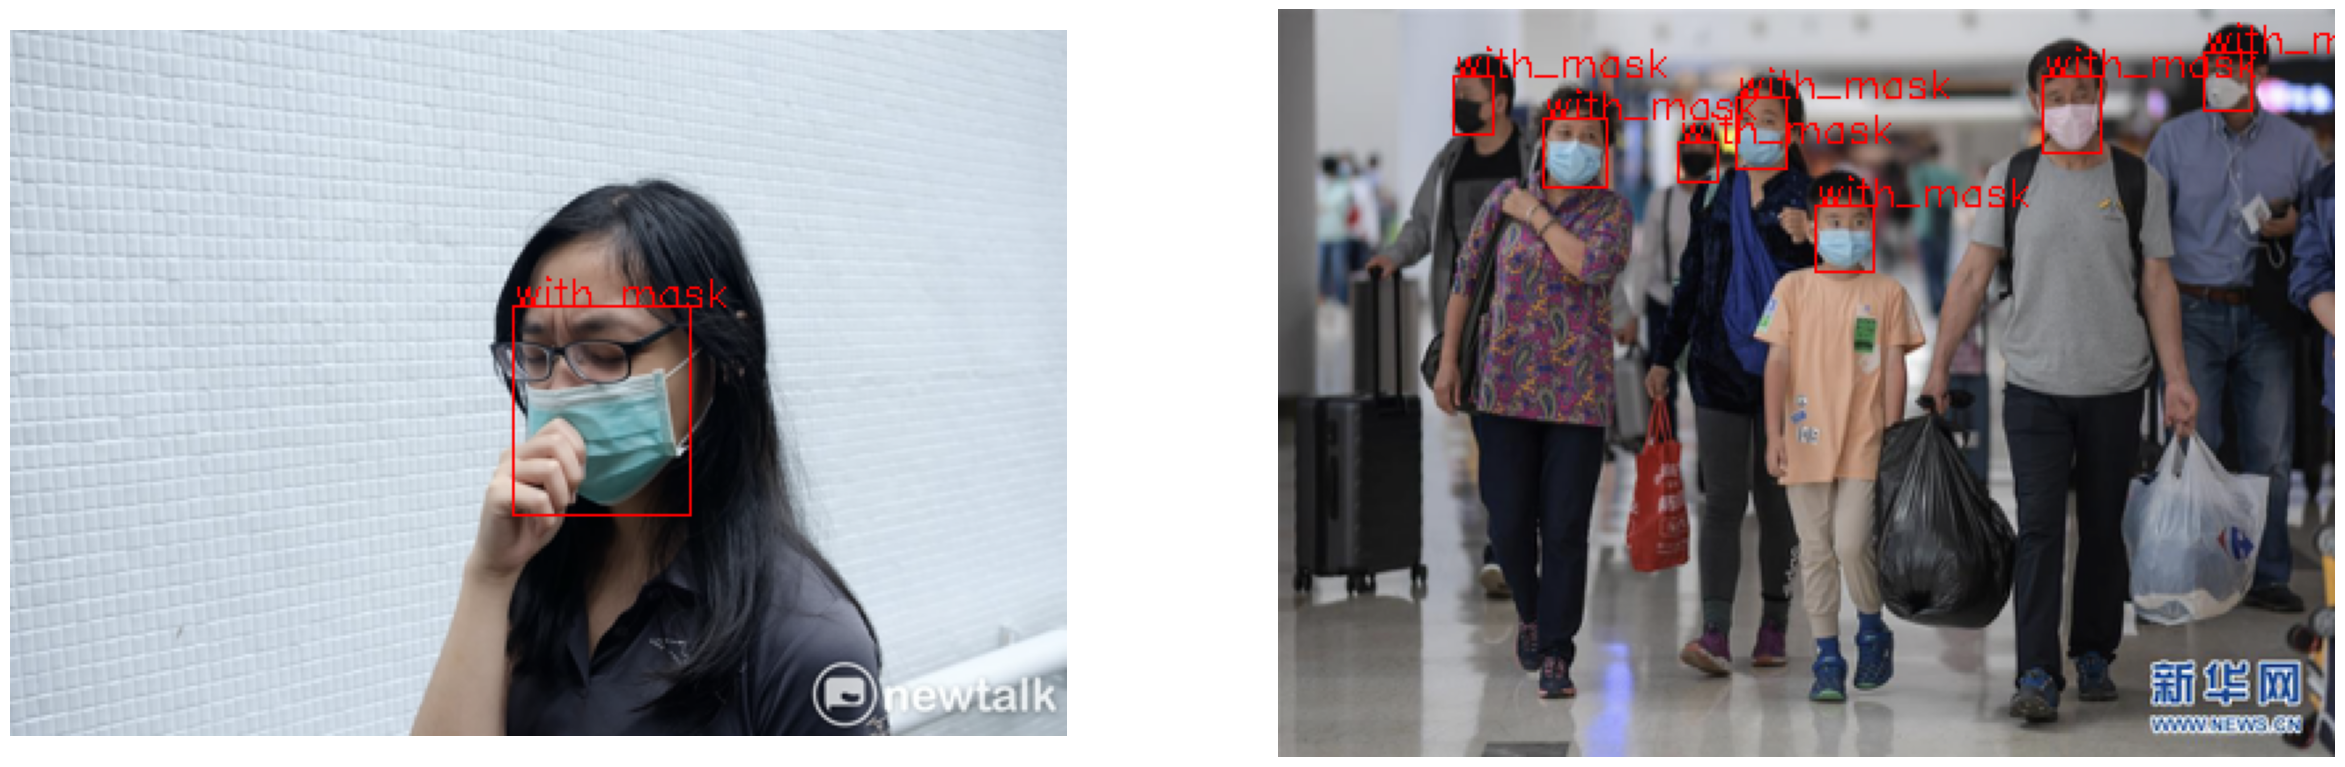

In [31]:
# Визуализируем случайный батч из валидационной выборки
vis_batch(val_data_loader)

# YOLO
В качестве детектора семейства YOLO будем использовать 11 версию. YOLO11 — это последняя итерация в серии классических Ultralytics YOLO детекторов объектов в реальном времени. Данная модель показывает лучшие результаты по сравнению с предыдущими версиями.

Создадим файл y_data.yaml, содержащий пути к нашим данным и расшифровку меток классов, следующего содержания:
```
# Dataset root directory relative to the yolov5 directory
path: data/

# Train/val/test sets: specify directories, *.txt files, or lists
train: images/train # images for training
val: images/val # images for validation

# Classes
names: 
    0: 'mask_weared_incorrect'
    1: 'with_mask'
    2: 'without_mask'

К сожалению [отключение отображения данных об обучении в режиме train недоступно](https://github.com/ultralytics/ultralytics/issues/17235) для данной реализации модели. Поэтому вывод следующей ячейки ноутбука удален.

In [ ]:
# Загружаем модель YOLO11 с предобученными весами
model = YOLO("yolo11m.pt")

# Фиксируем время начала и окончания обучения
start = time()

# Обучаем модель на наших данных в течении 50 эпох. Задаем размер изображений, 
# для автоматического определения размера батча определяем batch=-1, указываем путь к файлу data.yaml
results = model.train(data="data.yaml", batch=-1, epochs=50, imgsz=640, seed=42)

stop = time()

In [33]:
# Загружаем обученную нами модель и рассчитываем метрики для валидационной выборки средствами YOLO
model_detection = YOLO('runs/detect/train/weights/best.pt')
results_detection = model_detection.val(data='data.yaml')

Ultralytics 8.3.170 🚀 Python-3.10.18 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11002MiB)
YOLO11m summary (fused): 125 layers, 20,032,345 parameters, 0 gradients, 67.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3971.7±3353.4 MB/s, size: 336.1 KB)


val: Scanning /home/tio/CV/CV_git/Projects/Project_CV_2/data/labels/val.cache... 171 images, 0 backgrounds, 0 corrupt: 100%|██████████| 171/171 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.17it/s]


                   all        171        656      0.906      0.876      0.935      0.681
 mask_weared_incorrect         16         18      0.837      0.833      0.896      0.676
             with_mask        154        518      0.946      0.945       0.98      0.729
          without_mask         54        120      0.936      0.849      0.931      0.639
Speed: 0.5ms preprocess, 10.5ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/val2


In [34]:
# Выберем изображение для визуализации
img_name = os.listdir("data/images/val/")[75]

# Зададим путь к изображению из валидационной выборки
img_path = 'data/images/val/' + img_name

# Получим прогноз модели для изображения из тестовой выборки. 
# Можно передать список из нескольких изображений, но для наглядности ограничимся одним
results = model_detection.predict(img_path)


image 1/1 /home/tio/CV/CV_git/Projects/Project_CV_2/data/images/val/maksssksksss320.png: 384x640 4 with_masks, 1 without_mask, 36.0ms
Speed: 1.1ms preprocess, 36.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Целевое изображение: maksssksksss320.png


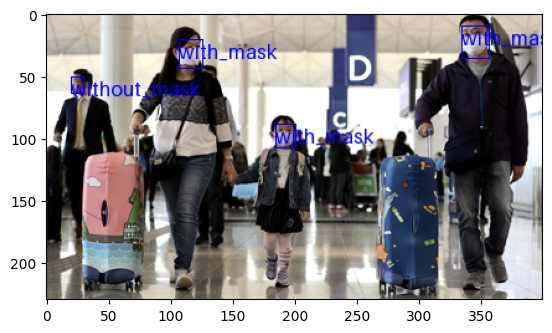

Прогноз модели для: maksssksksss320.png


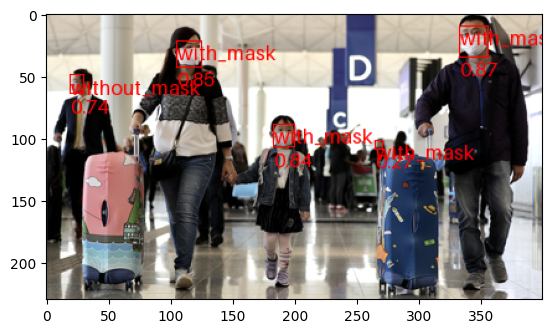

In [35]:
# Визуализируем целевое изображение и прогноз модели на выбранном изображении
print('Целевое изображение:', img_name)

# подготавливаем изображение
image=Image.open(img_path)

# Создаем объект Draw из нашего изображения для отображения на нем 
# ограничительных рамок (изображение отрисовывается в 4ой координатной четверти)
plotted_image = ImageDraw.Draw(image)

# получаем координаты для всех ограничительных рамок текущего изображения
bbox = xml_df[xml_df['filename']==img_name].to_numpy()

# В цикле перебираем все аннотации
for i, box in enumerate(bbox):
    
    # Получаем параметры текущей аннотации
    x0, y0, x1, y1 = box[-5:-1]
       
    # Отрисовываем на объекте Draw ограничительную рамку
    plotted_image.rectangle(((int(x0), int(y0)), (int(x1), int(y1))),
                            outline="blue",                                             
                            )
    
    # Добавляем метку класса
    lbl = xml_df[xml_df['filename']==img_name]['class'].to_numpy()[i]        
    plotted_image.text(xy=(x0, y0), # координаты метки 
                        text=lbl, # метка класса и
                        fill='blue',# цвет текста
                        font=ImageFont.load_default(size=16) # размер шрифта                     
                        )

# Преобразовываем массив в изображение и выводим его на экран
plt.imshow(np.array(image))
plt.show()

# Выводим результат прогноза модели
print('Прогноз модели для:', img_name)

# подготавливаем изображение
image=Image.open(img_path)

# Создаем объект Draw из нашего изображения для отображения на нем 
# ограничительных рамок (изображение отрисовывается в 4ой координатной четверти)
plotted_image = ImageDraw.Draw(image)



# получаем координаты для всех ограничительных рамок, уверенность модели и метки класса прогноза
for r in results:
    bbox = r.boxes.xyxy.clone().cpu().numpy()
    scores = r.boxes.conf.clone().cpu().numpy() 
    labels = r.boxes.cls.clone().cpu().numpy()

# В цикле перебираем полученные координаты bbox
for i, box in enumerate(bbox):
        
    # Получаем параметры текущей аннотации
    x0, y0, x1, y1 = box
      
    # Отрисовываем на объекте Draw ограничительную рамку
    plotted_image.rectangle(((int(box[0]),int(box[1])), (int(box[2]),int(box[3]))),
                            outline="red"
                            )
    
    # Добавляем метку класса и уверенность модели в этой метке
    lbl = class_id_to_name_mapping[labels[i]]
    scr = str(round(scores[i], 2)) 
    plotted_image.text(xy=(x0, y0), # координаты текста 
                        text=lbl, # метка класса
                        fill='red',# цвет текста
                        font=ImageFont.load_default(size=16) # размер шрифта                     
                        )
    plotted_image.text(xy=(x0, y1), # координаты текста
                       text= scr, # уверенность модели
                       fill='red',# цвет текста
                       font=ImageFont.load_default(size=16) # размер шрифта
                       )

# Преобразовываем массив в изображение и выводим его на экран
plt.imshow(np.array(image))
plt.show()

# освобождаем ресурсы памяти
plt.close()

Модель достаточно уверено определила истинные классы искомых объектов. Ограничительные рамки визуально совпадают с приведенными в аннотации. Однако присутствуют и ложные срабатывания на заднем плане определен человек в маске с низкой уверенностью 0.27. Фигура на заднем плане сильно размыта, но мне кажется, что там человек без маски, хотя ограничительная рамка визуально  расположена в правильной зоне.

In [36]:
# Создадим список для сбора метрики IoU 
iou_ls = []

# В цикле перебираем уникальные имена файлов изображений из валидационной выборки
for img_name in val_df['filename'].unique():
       
    # Зададим путь к изображению из валидационной выборки
    img_path = 'data/images/val/' + img_name

    # Получим прогноз модели для изображения из валидационной выборки
    results = model_detection.predict(img_path, verbose=False)
    
    # Извлечем тензор с координатами предсказанных ограничительных рамок 
    preds = results[0].boxes.xyxy
    
    # Создадим тензор с истинными координатами ограничительных рамок
    target = torch.tensor(xml_df[xml_df['filename']==img_name][['xmin', 'ymin', 'xmax', 'ymax']]
                          .values).to('cuda')
    
    # Вычислим метрику IoU и перенесем тензор на ЦПУ для дальнейшего преобразования в массив numpy
    metric_iou = torchvision.ops.box_iou(preds, target).to('cpu')
   
    # В результате мы получим двумерный тензор, где в столбцах будут истинные ответы, 
    # а в строках наши прогнозы. На пересечение значение метрики. Выполняем проверку - если прогнозов 
    # модели больше или столько же сколько истинных ответов, то преобразуем тензор в массив numpy и 
    # находим максимальное значение метрики для каждой строки - прогноза модели (чтобы учесть лишние 
    # прогнозы модели в метрике как ложные). Если прогнозов модели будет меньше чем истинных ответов,
    # то выполняем поиск максимума для каждого столбца - истинного ответа (чтобы учесть в метрики 
    # пропущенные моделью объекты)
    if metric_iou.size()[0] >= metric_iou.size()[1]:
        max_values = np.max(metric_iou.numpy(), axis=1)
        
    else:
        max_values = np.max(metric_iou.numpy(), axis=0)

    # И добавляем к списку метрик значения IoU для текущего изображения
    iou_ls.extend(max_values)

# Рассчитываем и выводим среднее значение метрики IoU для валидационной выборки
yolo_iou = round(np.mean(iou_ls), 2)
print('Среднее значение метрики IoU для валидационной выборки: ', yolo_iou)

Среднее значение метрики IoU для валидационной выборки:  0.77


In [37]:
# Задаем пустые списки для сбора результатов прогноза и истинных ответов на валидационной выборке
yolo_target_ls = []
yolo_preds = []

# В цикле перебираем изображения валидационной выборки
for img_name in tqdm(os.listdir("data/images/val/")):
    
    # Зададим путь к изображению из валидационной выборки
    img_path = 'data/images/val/' + img_name

    # Получим прогноз модели для изображения из валидационной выборки
    results = model_detection.predict(img_path, verbose=False)
    
    # Извлекаем из прогноза координаты ограничительных рамок, уверенность модели и метки классов
    for r in results:
        res_bbox = r.boxes.xyxy
        res_conf = r.boxes.conf
        res_lbl = r.boxes.cls.to(int) 
    
    # Сохраняем прогноз модели в список    
    yolo_preds.append({'boxes':res_bbox,
                       'labels':res_lbl,
                       'scores':res_conf,
                       'img_name':img_name
                       }
                      )
    
    # Создадим тензор с истинными координатами ограничительных рамок
    target_boxes = torch.tensor(val_df[val_df['filename']==img_name][['xmin', 'ymin', 'xmax', 'ymax']]
                                .values).to('cuda')
    
    target_labels = torch.tensor(val_df[val_df['filename']==img_name]['label'].values).to('cuda')
    
    # Сохраняем аннотации в список
    yolo_target_ls.append({'boxes':target_boxes,
                           'labels':target_labels,
                           'img_name':img_name
                           }
                          )

100%|██████████| 171/171 [00:03<00:00, 47.64it/s]


In [38]:
# Для модели FRCNN расчет метрик mAP будем проводить с помощью модуля torchmetrics.detection 
# поэтому для корректного сравнения пересчитаем метрики для модели YOLO.
# Создаем объект класса MeanAveragePrecision из модуля torchmetrics.detection 
metric_yolo = MeanAveragePrecision(iou_type="bbox", class_metrics=True)

# Передаем полученные списки в объект класса MeanAveragePrecision
metric_yolo.update(yolo_preds, yolo_target_ls)

# Расчитываем метрику для тестовой выборки
result_yolo = metric_yolo.compute()

# Выводим результат
display(result_yolo)

{'map': tensor(0.6534),
 'map_50': tensor(0.8937),
 'map_75': tensor(0.7768),
 'map_small': tensor(0.5593),
 'map_medium': tensor(0.7406),
 'map_large': tensor(0.8522),
 'mar_1': tensor(0.3957),
 'mar_10': tensor(0.6871),
 'mar_100': tensor(0.7001),
 'mar_small': tensor(0.6007),
 'mar_medium': tensor(0.7843),
 'mar_large': tensor(0.8631),
 'map_per_class': tensor([0.6570, 0.7039, 0.5994]),
 'mar_100_per_class': tensor([0.7111, 0.7485, 0.6408]),
 'classes': tensor([0, 1, 2], dtype=torch.int32)}

In [39]:
# Создаем датафрейм для сбора значений метрики iou
yolo_df = pd.DataFrame()

# Создаем цикл длиной равной количеству изображений в валидационной выборке
for i in range(len(yolo_preds)):
    
    # Создаем датафрейм для сбора значений метрики iou текущего изображения
    df = pd.DataFrame()
        
    # получаем переменные для текущего изображения: координаты ограничительных 
    # рамок прогноза и истинного ответа, наименование файла, метки классов прогноза 
    # и истиного ответа, уверенность модели в прогнозе и обновляем значение счетчика 
    # исходного количества истинных ответов
    predict_boxs = yolo_preds[i]['boxes']
    target_boxs = yolo_target_ls[i]['boxes']
    img_name = yolo_preds[i]['img_name']
    predict_labels = yolo_preds[i]['labels']
    target_labels = yolo_target_ls[i]['labels']
    conf_scores = yolo_preds[i]['scores']
    
    # В цикле перебираем все истинные ответы
    for num, target_box in enumerate(target_boxs):
            
        # В цикле проходим по всем прогнозам
        for num_box in range(len(predict_boxs)):
            
            # Вычисляем координаты области пересечения ограничительных рамок текщего 
            # истинного ответа и каждого прогноза
            xmin = max([predict_boxs[num_box][0], target_box[0]])
            ymin = max([predict_boxs[num_box][1], target_box[1]])
            xmax = min([predict_boxs[num_box][2], target_box[2]])
            ymax = min([predict_boxs[num_box][3], target_box[3]])
            
            # Выполним проверку что текущий прогноз имеет пересечение с текущим истинным ответом
            if ((xmax - xmin) > 0) & ((ymax - ymin) > 0):
                
                # Если пересечение имеется считаем его площадь, площади самих ограничительных рамок и
                # площадь их объединения
                intersection = (xmax - xmin) * (ymax - ymin)
                s_pred = (predict_boxs[num_box][2] - predict_boxs[num_box][0]) * (predict_boxs[num_box][3] - predict_boxs[num_box][1])
                s_target = (target_box[2] - target_box[0]) * (target_box[3] - target_box[1])
                union = s_pred + s_target - intersection
                
                # Вычисляем метрику и преобразуем её в список
                iou = intersection / union
                iou = iou.cpu().tolist()
            
            # Иначе значение метрики IoU будет равно 0 
            else:
                iou = 0
            
            # Собираем результаты для текущего прогноза и истинного ответа в вспомогательный датафрейм
            df_row = pd.DataFrame(data = {'filename':[img_name],
                                          'num_predict':[num_box],
                                          'num_target':[num],
                                          'predict_box':[predict_boxs[num_box].cpu().tolist()],
                                          'target_box':[target_box.cpu().tolist()],
                                          'target_label':[target_labels[num].cpu().tolist()],
                                          'predict_label':[predict_labels[num_box].cpu().tolist()],
                                          'conf_score':[conf_scores[num_box].cpu().tolist()],
                                          'iou':[iou]
                                          }
                                  )
            
            # Добавляем его к датафрейму текущего изображения
            df = pd.concat([df, df_row], axis=0, ignore_index=True)
        
    # С помощью сортировки получаем максимальное значение метрики для каждого истинного ответа на текущем изображении
    df = df.sort_values(['num_target', 'iou'], ascending=[True, False]).drop_duplicates('num_target')
    
    # Если существует истинный ответ со значением метрики 0, значит модель его не обнаружила (FN). 
    # Присвоим таким ответам значение метрики 200 для дальнейшей отработки
    df.loc[df['iou'] == 0, 'iou'] = 200
    
    # Обработаем случая когда прогноз является ложно положительным, т.е. прогнозов больше чем истинных ответов. 
    # Сравниваем количество оставшихся в датафрейме прогнозов с их исходным количеством
    if df['num_predict'].nunique() < len(predict_boxs):
        
        # Если прогнозов осталось меньше, то находим недостающий номер прогноза            
        for num_predict in range(len(predict_boxs)):
            if num_predict not in df['num_predict'].unique():
                
                # Формируем и добавляем строку в датафрейм со значением метрики 100 для дальнейшей обработки 
                df_row = pd.DataFrame(data = {'filename':[img_name],
                                            'num_predict':[num_predict],
                                            'num_target':['no'],
                                            'predict_box':[predict_boxs[num_predict].cpu().tolist()],
                                            'target_box':['no'],
                                            'target_label':['no'],
                                            'predict_label':[predict_labels[num_predict].cpu().tolist()],
                                            'conf_score':[conf_scores[num_predict].cpu().tolist()],
                                            'iou':[100]
                                            }
                                    )
                # и добавляем её к датафрейму
                df = pd.concat([df, df_row], axis=0, ignore_index=True)
    
    # Добавляем полученный для текущего изображения датафрейм к результирующему датафрейму
    yolo_df = pd.concat([yolo_df, df], axis=0)

# Проверяем результат    
display(yolo_df.head())

filename  num_predict num_target  \
0   maksssksksss333.png            0          0   
0   maksssksksss246.png            0          0   
5   maksssksksss246.png            1          1   
11  maksssksksss246.png            3          2   
14  maksssksksss246.png            2          3   

                                          predict_box            target_box  \
0   [75.87711334228516, 200.8049774169922, 178.251...   [76, 203, 181, 330]   
0   [237.18023681640625, 106.80671691894531, 265.5...  [238, 106, 266, 138]   
5   [192.58444213867188, 127.80387115478516, 211.2...  [192, 130, 212, 150]   
11  [15.629024505615234, 18.297489166259766, 68.02...      [21, 25, 69, 78]   
14  [336.6587829589844, 152.1102294921875, 343.260...  [336, 151, 344, 160]   

   target_label  predict_label  conf_score       iou  
0             1              1    0.881784  0.952731  
0             1              1    0.873823  0.903076  
5             1              1    0.851045  0.795838  
11            1              1    0.476254  0.775144  
14            1              1    0.650537  0.668343

In [40]:
# Задаем списки для сбора метрик и порог IoU
precision_ls = []
recall_ls = []
tresh_iou = 0.5

# В цикле перебираем пороговые значения уверенности модели
for tresh_conf in np.linspace(0.0, 0.9, 10):
    
    # Задаем переменные для подсчета оценок
    tp = 0
    fp = 0
    fn = 0
    
    # В цикле перебираем строки результирующего датафрейма
    for row in yolo_df.iterrows():
        
        # Если метрика IoU имеет значение 100, значит этот прогноз не соответствует ни одному
        # истинному ответу из аннотаций (например, прогнозов больше чем ответов), т.е. является
        # ложно положительным
        if row[1]['iou'] == 100:
            
            # Если увереность модели выше текущего порога, считаем ответ ложноположительным
            if (row[1]['conf_score'] >= tresh_conf):
                fp += 1
        
        # Если метрика IoU равна 200, значит этому истинному ответу не нашлось ни одного прогноза 
        # с хоть каким-нибудь пересечением ограничительной рамки (например, ответов больше прогнозов), 
        # т.е. это ложно отрицательный случай     
        elif row[1]['iou'] == 200:
            fn += 1
  
        # Если значение метрики IoU больше или равно заданному порогу, класс предсказан верно и уверенность модели больше или равна порогу,
        # то это верный положительный прогноз          
        elif ((row[1]['iou'] >= tresh_iou) and (row[1]['target_label'] == row[1]['predict_label']) and (row[1]['conf_score'] >= tresh_conf)):
            tp += 1
         
        # Если значение метрики IoU больше или равно заданному порогу, но при этом класс неправильный или если значение метрики IoU меньше 
        # порога (т.е. считаем что пересечение с рамкой истинного ответа недостаточно/отсутствует) считаем ответ ложно положительным
        elif ((row[1]['iou'] >= tresh_iou) and (row[1]['target_label'] != row[1]['predict_label']) and (row[1]['conf_score'] >= tresh_conf)) \
            or ((row[1]['iou'] < tresh_iou) and (row[1]['conf_score'] >= tresh_conf)):              
            fp +=1
            
        # Если уверенность модели ниже порога при правильном ответе считаем ответ ложноотрицательным
        elif ((row[1]['iou'] >= tresh_iou) and (row[1]['target_label'] == row[1]['predict_label']) and (row[1]['conf_score'] < tresh_conf)):
            fn += 1

    # Добавляем в соответствующие списки рассчитанные значения метрик
    precision_ls.append(tp / (tp + fp) if (tp + fp) > 0 else 0)
    recall_ls.append(tp / (tp + fn) if (tp + fn) > 0 else 0)

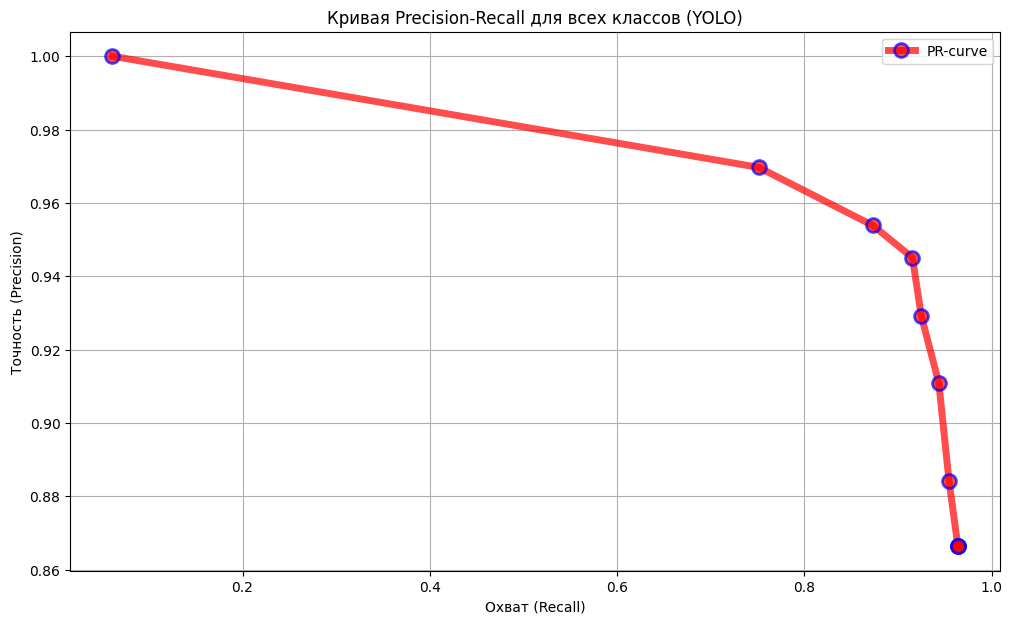

In [41]:
# Создаем фигуру
plt.figure(figsize=(12, 7))

# Отображаем PR кривую        
plt.plot(recall_ls, precision_ls, 'o-r', alpha=0.7, label="PR-curve", lw=5, mec='b', mew=2, ms=10)

# Настраиваем отображение
plt.xlabel('Охват (Recall)')    
plt.ylabel('Точность (Precision)')
plt.title('Кривая Precision-Recall для всех классов (YOLO)')    
plt.legend()
plt.grid(True)


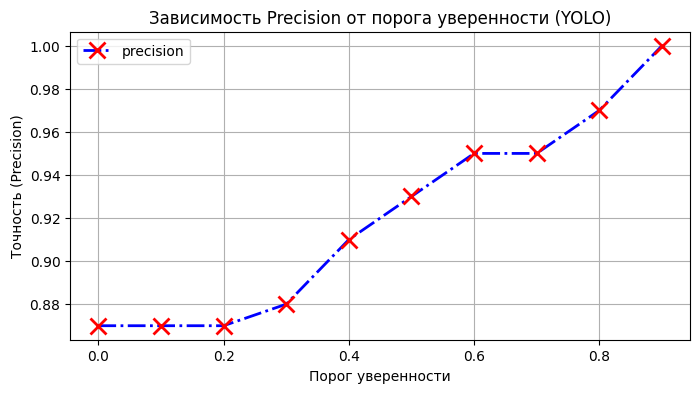

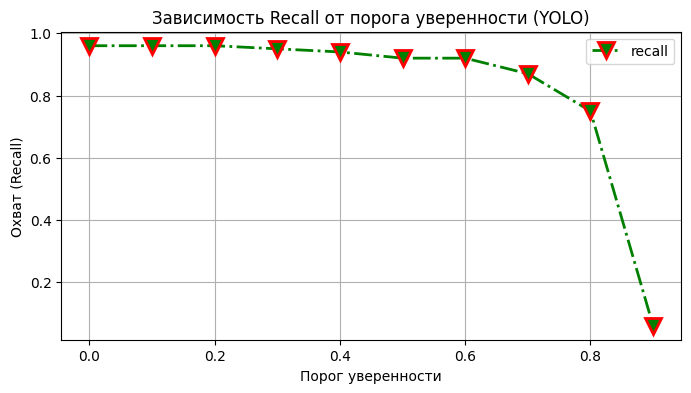

In [42]:
# Построим графики изменения Precision и Recall при различных порогах уверенности
# Создаем фигуру
plt.figure(figsize=(8, 4))

# Строим кривую зависимости точности от порога уверенности модели
plt.plot(np.linspace(0.0, 0.9, 10), np.round(precision_ls, 2), 'x-.b', label="precision", mec='r', lw=2, mew=2, ms=12)

# Настраиваем отображение
plt.xlabel('Порог уверенности')    
plt.ylabel('Точность (Precision)')
plt.title('Зависимость Precision от порога уверенности (YOLO)')
plt.legend()
plt.grid(True)

# Создаем фигуру
plt.figure(figsize=(8, 4))

# Строим кривую зависисмости охвата от порога уверенности модели
plt.plot(np.linspace(0.0, 0.9, 10), np.round(recall_ls, 2), 'v-.g', label="recall", mec='r', lw=2, mew=2, ms=12)

# Настраиваем отображение
plt.xlabel('Порог уверенности')    
plt.ylabel('Охват (Recall)')
plt.title('Зависимость Recall от порога уверенности (YOLO)')
plt.legend()
plt.grid(True)

По графикам для всех классов видно что оптимальный порог уверенности для данной модели 0.8. При этом значении Precision имеет значение 0.97, а Recall опускается до величины 0.78. Проверим как выглядят графики для каждого из классов.

In [ ]:
# Построим PR-кривые для каждого класса
# Задаем порог IoU и словари для сбора метрик по классам
tresh_iou = 0.5
p_dict = {}
r_dict = {}

# В цикле перебираем метки классов
for i in [0, 1, 2]:
    
    # Создаем списки для сбора метрик текущего класса
    precision_ls = []
    recall_ls = []

    # В цикле перебираем пороговые значения уверенности модели
    for tresh_conf in np.linspace(0.0, 0.9, 10):
        
        # Задаем переменные для подсчета оценок
        tp = 0
        fp = 0
        fn = 0
        
        # При подсчете IoU код 100 присваивался для всех прогнозов, которые не соответствует ни одному
        # истинному ответу из аннотаций (например, прогнозов больше чем ответов), код 200 - для всех истинных 
        # ответов которым не нашлось ни одного прогноза с хоть каким-нибудь пересечением ограничительной 
        # рамки (например, ответов больше прогнозов). Фильтруем датасет по классам и увеличиваем счетчики оценок 
        # на соответствующее классу количество кодов (200 для fn) 
        fn = yolo_df[(yolo_df['iou']==200)&(yolo_df['predict_label'] == i)].shape[0]
        
        # В цикле перебираем строки результирующего датафрейма отфильтрованные по текущему классу и не содержащие специальный код 200
        for row in yolo_df[(yolo_df['target_label']==i)&(yolo_df['iou'] != 200)].iterrows():
            
            # Если метрика IoU имеет значение 100, значит этот прогноз не соответствует ни одному
            # истинному ответу из аннотаций (например, прогнозов больше чем ответов), т.е. является
            # ложно положительным
            if row[1]['iou'] == 100:
            
                # Если увереность модели выше текущего порога, считаем ответ ложноположительным
                if (row[1]['conf_score'] >= tresh_conf):
                    fp += 1
        
            # Если значение метрики IoU больше или равно заданному порогу, класс предсказан верно и уверенность модели больше или равна порогу,
            # то это верный положительный прогноз          
            elif ((row[1]['iou'] >= tresh_iou) and (row[1]['target_label'] == row[1]['predict_label']) and (row[1]['conf_score'] >= tresh_conf)):
                tp += 1
           
            # Если значение метрики IoU и уверенность модели больше или равны заданным порогам, но при этом класс неправильный или если значение метрики IoU меньше 
            # порога при уверенности модели большей или равной порогу считаем что пересечение с рамкой истинного ответа недостаточно/отсутствует
            elif ((row[1]['iou'] >= tresh_iou) and (row[1]['target_label'] != row[1]['predict_label']) and (row[1]['conf_score'] >= tresh_conf)) \
                or ((row[1]['iou'] < tresh_iou) and (row[1]['conf_score'] >= tresh_conf)):              
                fp +=1
                
            # Если уверенность модели ниже порога при правильном ответе считаем ответ ложноотрицательным
            elif ((row[1]['iou'] >= tresh_iou) and (row[1]['target_label'] == row[1]['predict_label']) and (row[1]['conf_score'] < tresh_conf)):
                fn += 1
                
        # Добавляем в соответствующие списки рассчитанные значения метрик
        precision_ls.append(tp / (tp + fp) if (tp + fp) > 0 else 0)
        recall_ls.append(tp / (tp + fn) if (tp + fn) > 0 else 0)
    
    # Заносим полученные списики в словари по ключу - индексу класса
    p_dict[i] = precision_ls
    r_dict[i] = recall_ls

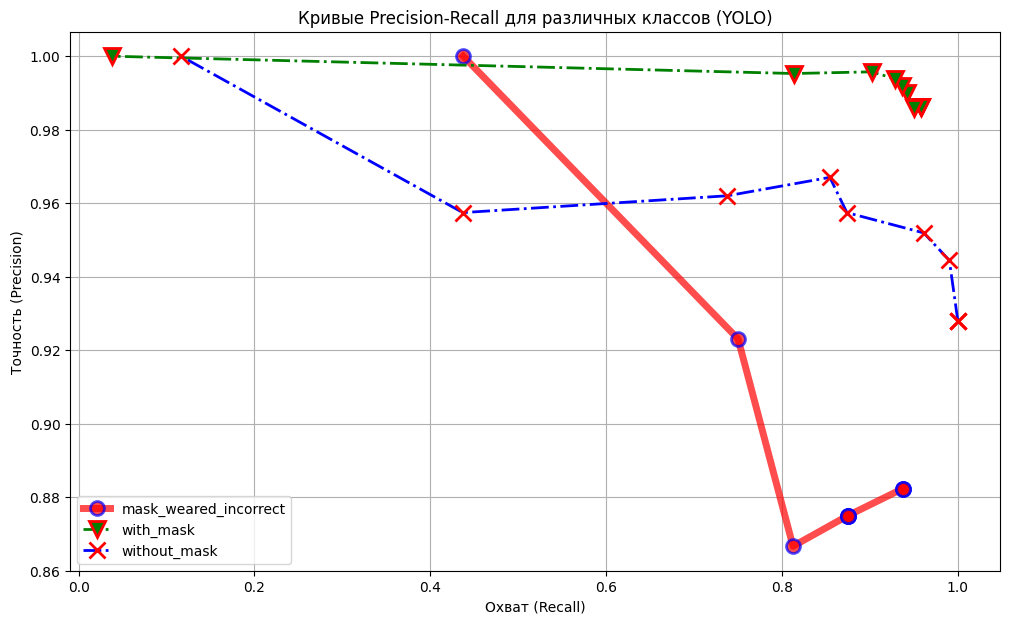

In [53]:
# Задаем размер фигуры
plt.figure(figsize=(12, 7))

# Отображаем PR кривые для каждого класса 
plt.plot(r_dict[0], p_dict[0], 'o-r', alpha=0.7, label=class_id_to_name_mapping[0], lw=5, mec='b', mew=2, ms=10)
plt.plot(r_dict[1], p_dict[1], 'v-.g', label=class_id_to_name_mapping[1], mec='r', lw=2, mew=2, ms=12)
plt.plot(r_dict[2], p_dict[2], 'x-.b', label=class_id_to_name_mapping[2], mec='r', lw=2, mew=2, ms=12)

# Настраиваем отображение
plt.xlabel('Охват (Recall)')
plt.ylabel('Точность (Precision)')
plt.title('Кривые Precision-Recall для различных классов (YOLO)')
plt.legend()
plt.grid(True)

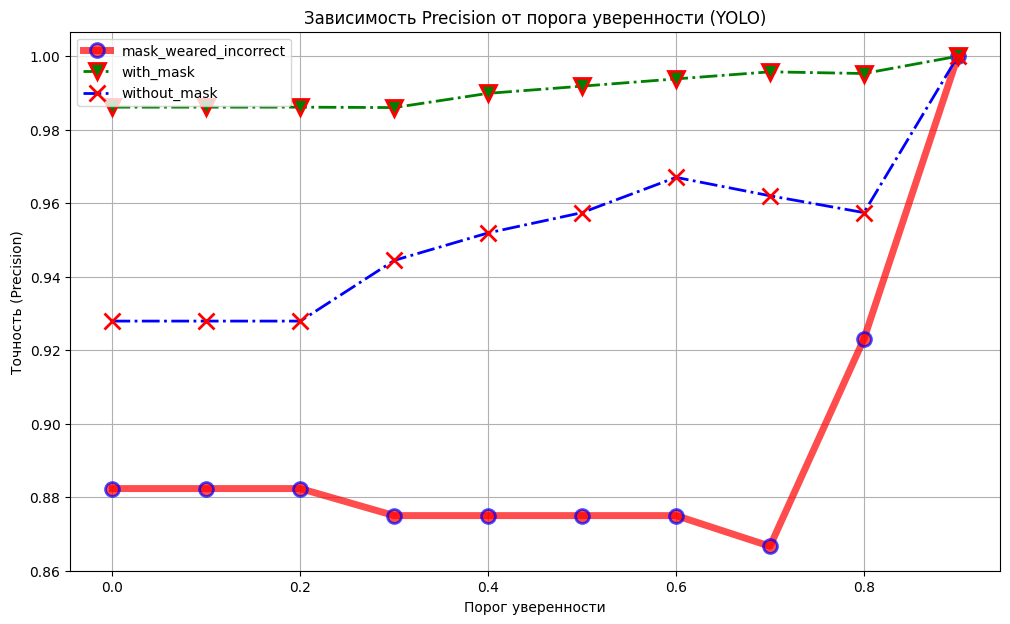

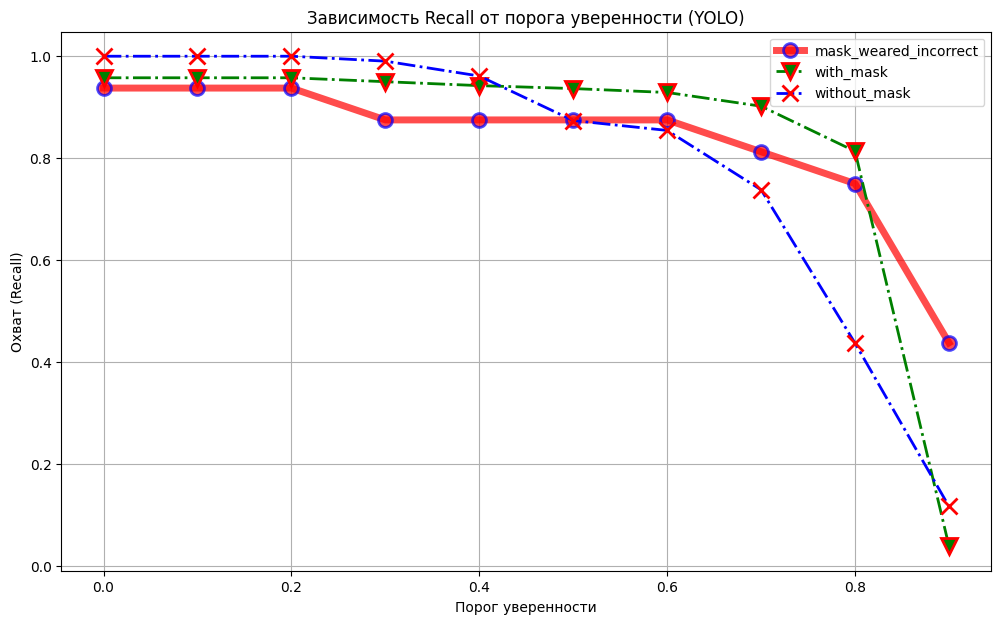

In [ ]:
# Создаем фигуру
plt.figure(figsize=(12, 7))

# Определяем метки для оси Х
x = np.linspace(0.0, 0.9, 10)

# Строим кривую зависимости точности от порога уверенности модели для каждого класса 
plt.plot(x, p_dict[0], 'o-r', alpha=0.7, label=class_id_to_name_mapping[0], lw=5, mec='b', mew=2, ms=10)
plt.plot(x, p_dict[1], 'v-.g', label=class_id_to_name_mapping[1], mec='r', lw=2, mew=2, ms=12)
plt.plot(x, p_dict[2], 'x-.b', label=class_id_to_name_mapping[2], mec='r', lw=2, mew=2, ms=12)

# Настраиваем отображение
plt.xlabel('Порог уверенности')    
plt.ylabel('Точность (Precision)')
plt.title('Зависимость Precision от порога уверенности (YOLO)')
plt.legend()
plt.grid(True)

# Создаем фигуру
plt.figure(figsize=(12, 7))

# Строим кривую зависисмости охвата от порога уверенности для каждого класса 
plt.plot(x, r_dict[0], 'o-r', alpha=0.7, label=class_id_to_name_mapping[0], lw=5, mec='b', mew=2, ms=10)
plt.plot(x, r_dict[1], 'v-.g', label=class_id_to_name_mapping[1], mec='r', lw=2, mew=2, ms=12)
plt.plot(x, r_dict[2], 'x-.b', label=class_id_to_name_mapping[2], mec='r', lw=2, mew=2, ms=12)

# Настраиваем отображение
plt.xlabel('Порог уверенности')    
plt.ylabel('Охват (Recall)')
plt.title('Зависимость Recall от порога уверенности (YOLO)')
plt.legend()
plt.grid(True)

Ожидаемо, что лучшего всего график выглядит для преобладающего класса. Но класс "некорректно одетая маска" портит картину. Судя по графикам для достаточно хорошей работы по каждому из классов стоит установить порог уверенности 0.6. При этом минимальное значение метрики Precision имеет значение около 0.88, а Recall около 0.83. Для дальнейшего улучшения метрик можно попробовать сбор дополнительных данных по минорным классам.

In [ ]:
# Сформируем словарь с результатами
result_dict = {'model': ['YOLO v11m'],
               'parameters': [20032345],
               'GFLOPs': [67.7],
               'train_time, s': [round(stop - start)],
               'time_per_epoch, s': [round((stop - start)/50)],
               'mAP_50': [0.89],
               'mAP_50_95': [0.65],
               'iou':[0.77]
               }

# Преобразуем его в датафрейм и отобразим результат
df = pd.DataFrame(data=result_dict)
display(df)

# Запишем результат в файл
df.to_csv('results_df.csv', index=False, header=True)


model  parameters  GFLOPs  train_time, s  time_per_epoch, s  mAP_50  \
0  YOLO v11m    20032345    67.7            790                 16    0.89   

   mAP_50_95   iou  
0       0.65  0.77

# FRCNN

В качестве детектора семейства FRCNN выберем fasterrcnn_resnet50_fpn_v2, являющуюся улучшенной версией Faster RCNN ResNet50 и наиболее современной среди доступных в PyTorch на данный момент моделей даного семейства.

## Загрузка модели

In [ ]:
# По возможности переключаемся на видеокарту
use_gpu = torch.cuda.is_available()
if use_gpu:
    device = 'cuda'
else:
    device = 'cpu'

print(device)

cuda


In [ ]:
# Загружаем модель с предобученными весами
model_rcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights='DEFAULT')

# Получаем число классов и увеличиваем его на 1 так как 0 - это класс фона
num_classes = frcnn_train_df['class'].nunique() + 1 

# Получим число входных признаков для классификатора
in_features = model_rcnn.roi_heads.box_predictor.cls_score.in_features

# Заменим классификатор на новый
model_rcnn.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
# Определяем функцию для обучения в течение одной эпохи
def epoch_train(model, mode, dataloader, optimizer):
    """Функция для выполнения обучения на одной эпохе

    Args:
        model (models.common.AutoShape): модель
        mode (str): наименование режима ('train' для обучения)
        dataloader (torch.utils.data.dataloader.DataLoader): даталоадер
        optimizer (torch.optim): оптимизатор
    Returns:
        numpy.float64: среднее значение суммарной ошибки за эпоху
    """
    
    # Включаем подсчет градиентов если текущий режим train
    if mode == 'train':        
        torch.set_grad_enabled(True)
    # Иначе - отключаем
    else:        
        torch.set_grad_enabled(False)
    
    # Задаем пустой список для сбора ошибок модели на батче  
    epoch_loss = []
    
    # В цикле проходим по всем батчам в даталоадере   
    for images, targets, _ in dataloader:
        
        # Переносим изображение и аннотацию на используемое устройство
        images = [image.to(device) for image in images]
        targets = [{key: val.to(device) for key, val in t.items()} for t in targets]
                
        # Выполняем прямой проход
        loss_dict = model(images, targets)
        
           
        # Заносим в переменную суммарную ошибку на текущем батче
        batch_loss = sum(loss_val for loss_val in loss_dict.values())
        
        # Преобразуем значение оштбки в число методом .item() и записываем значение в список потерь
        epoch_loss.append(batch_loss.item())   
        
        # Если текущий режим 'train', выполняем обратный проход
        if mode == 'train':
            with torch.no_grad():                        
                optimizer.zero_grad()
                batch_loss.backward()
                optimizer.step()
                
    # Возвращаем среднее значение суммарной ошибки за эпоху
    return np.mean(epoch_loss)

      
# Определим функцию для обучения модели
def train_model(model, train_dataloader, val_dataloader, optimizer, num_epochs):
    """Функция для обучения модели. Модель с наименьшей суммарной ошибкой за эпоху 
    на валидационной выборке сохраняется в корневой папке.

    Args:
        model (models.common.AutoShape): модель
        train_dataloader (torch.utils.data.dataloader.DataLoader): обучающий даталоадер
        val_dataloader (torch.utils.data.dataloader.DataLoader): валидационный даталоадер
        optimizer (torch.optim): оптимизатор
        num_epochs (int): количество эпох обучения

    Returns:
        tuple: кортеж из списков средних значений суммарных ошибок модели на эпохах для 
        тренировочной и валидационной выборок
    """
    # Задаем списки для сбора ошибок модели и времени работы на эпохах
    train_loss = []
    val_loss = []
    epoch_time = []
        
    # Переводим модель в режим обучения
    model.train()
    
    # Задаем начальное порговое значение ошибки
    min_loss = 10e6
    
    # В цикле передвигаемся по количеству эпох
    for epoch in tqdm(range(num_epochs)):
        
        # Запоминаем время начала эпохи
        start_time = time()
        
        # На каждой эпохе вызываем определенную выше функцию в режиме обучения и в режиме валидации, 
        # занося полученнле значение ошибки в соответствующий список
        loss = epoch_train(model=model, mode='train', dataloader=train_dataloader, optimizer=optimizer)
        train_loss.append(loss)
        loss = epoch_train(model=model, mode='val', dataloader=val_dataloader, optimizer=optimizer)
        val_loss.append(loss)
        
        # Проверяем, что среднее значение суммарной ошибки за эпоху на валидационной выборке ниже
        # порогового значения
        if loss < min_loss:
            
            # если это так, обновляем пороговое значение
            min_loss = loss
            
            # и сохраняем модель как лучший результат
            torch.save(model, 'FRCNN_best.pth')
            
            # выводим сообщение о сохранении
            print('Epoch ', epoch, ' save model: done')
        
        # Фиксируем время окончания эпохи и заносим в список длительность текущей эпохи
        stop_time = time()    
        epoch_time.append(stop_time - start_time)

    # Включаем подсчет градиентов                       
    torch.set_grad_enabled(True)
    
    # Возвращаем кортеж из списков средних значений суммарных ошибок модели на эпохах 
    # для тренировочной и валидационной выборок   
    return train_loss, val_loss, epoch_time


In [ ]:
# Переносим модель на используемое устройство
model_rcnn.to(device)

# Задаем параметры оптимизатора
params = [p for p in model_rcnn.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005)

In [ ]:
# Запускаем обучение модели
train_loss, val_loss, epoch_time = train_model(model=model_rcnn,
                                               optimizer=optimizer,
                                               train_dataloader=train_data_loader,
                                               val_dataloader=val_data_loader,
                                               num_epochs=50
                                               )

  2%|▏         | 1/50 [02:27<2:00:38, 147.73s/it]

Epoch  0  save model: done


  4%|▍         | 2/50 [04:58<1:59:26, 149.30s/it]

Epoch  1  save model: done


  6%|▌         | 3/50 [07:27<1:57:09, 149.55s/it]

Epoch  2  save model: done


  8%|▊         | 4/50 [09:57<1:54:38, 149.53s/it]

Epoch  3  save model: done


 10%|█         | 5/50 [12:25<1:51:41, 148.93s/it]

Epoch  4  save model: done


 16%|█▌        | 8/50 [20:03<1:46:09, 151.66s/it]

Epoch  7  save model: done


 18%|█▊        | 9/50 [22:44<1:45:45, 154.76s/it]

Epoch  8  save model: done


 30%|███       | 15/50 [38:08<1:28:44, 152.13s/it]

Epoch  14  save model: done


100%|██████████| 50/50 [2:10:52<00:00, 157.06s/it]  


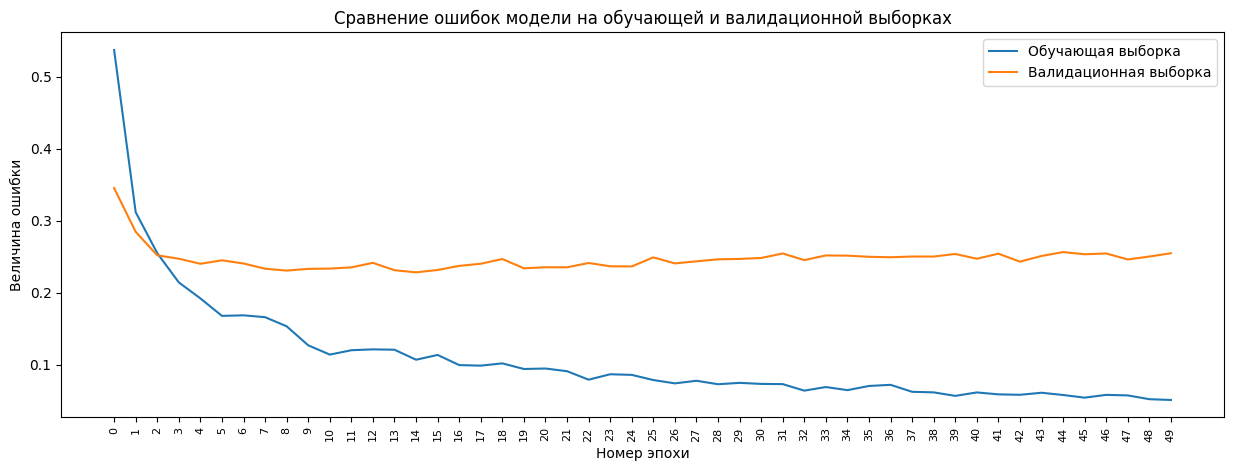

In [ ]:
# Визуализиреум ошибки модели на обучающей и валидационной выборках
# Создаем фигуру
plt.figure(figsize=(15, 5))

# Определяем количество эпох для отображения по оси Х
x = range(len(train_loss))

# Строим графики ошибок модели на обучающей и валидационной выбороках
plt.plot(x, train_loss, label='Обучающая выборка')
plt.plot(x, val_loss, label='Валидационная выборка')

# Настраиваем отображение
plt.title('Сравнение ошибок модели на обучающей и валидационной выборках')
plt.legend()
plt.xticks(ticks=x, fontsize=8, rotation=90)
plt.xlabel('Номер эпохи')
plt.ylabel('Величина ошибки')
plt.show()

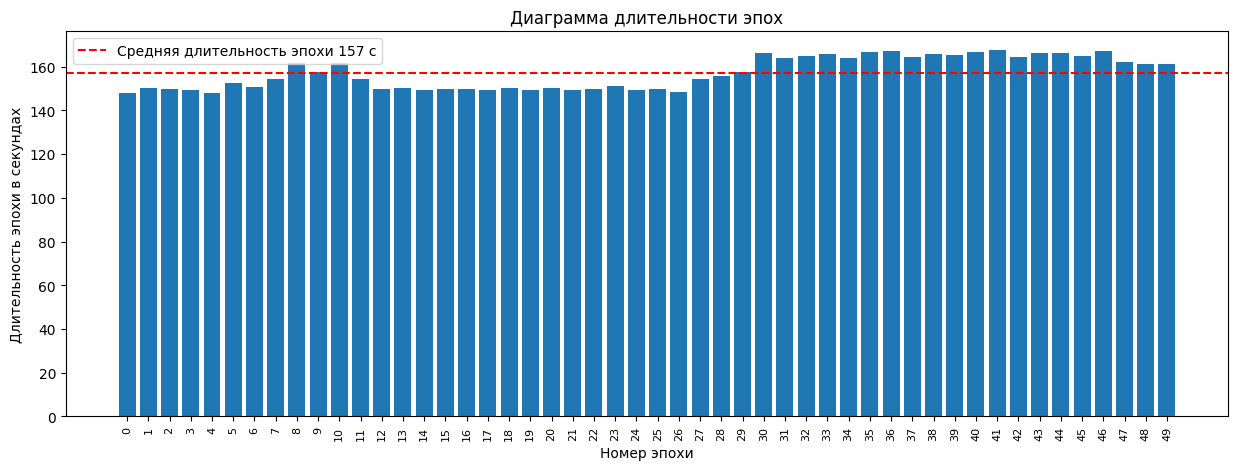

In [ ]:
# Визуализиреум длительность эпох
# Создаем фигуру
plt.figure(figsize=(15, 5))

# Определяем количество эпох для отображения по оси Х
x = range(len(epoch_time))

# Строим столбчатую диаграмму длительности эпох
plt.bar(x, epoch_time, align='center')

plt.axhline(y=np.mean(epoch_time),
            color='red',
            linestyle='--',
            label=f'Средняя длительность эпохи {int(np.mean(epoch_time))} с')

# Настраиваем отображение
plt.legend()
plt.title('Диаграмма длительности эпох')
plt.xticks(ticks=x, fontsize=8, rotation=90)
plt.xlabel('Номер эпохи')
plt.ylabel('Длительность эпохи в секундах')
plt.show()

In [ ]:
# Загружаем лучшую модель сохраненную при обучении
f_rcnn_model = torch.load('FRCNN_best.pth', weights_only=False)

# Переносим модель на используемое устройство
f_rcnn_model.to(device)

# Задаем пустые списки для сбора результатов прогноза и истинных ответов
f_rcnn_target_ls = []
f_rcnn_preds=[]
ind_img =[]

# В цикле получаем батчи изображений и аннотации к ним
for images, targets, image_ids in tqdm(val_data_loader):
    
    # Заносим наименование изображения в список
    ind_img.extend(image_ids)
    
    # переносим тензоры изображений и аннотаций на устройство (CUDA/cpu)
    img = [i.to(device) for i in images] 
    target = [{k: v.to(device) for k, v in t.items()} for t in targets]

    # Сохраняем аннотации в список
    f_rcnn_target_ls.extend(target)
    
    # Переводим модель в режим оценки и отключаем подсчет градиентов
    f_rcnn_model.eval()
    with torch.no_grad():
        result = f_rcnn_model(img)
    
    # Сохраняем прогноз модели в список    
    f_rcnn_preds.extend(result)

100%|██████████| 86/86 [00:17<00:00,  4.88it/s]


In [ ]:
# Создаем объект класса MeanAveragePrecision из модуля torchmetrics.detection 
metric_rcnn = MeanAveragePrecision(iou_type="bbox", class_metrics=True)

# Передаем полученные списки в объект класса MeanAveragePrecision
metric_rcnn.update(f_rcnn_preds, f_rcnn_target_ls)

# Расчитываем метрику для тестовой выборки
result_iou = metric_rcnn.compute()

# Выводим результат
display(result_iou)

{'map': tensor(0.5594),
 'map_50': tensor(0.8855),
 'map_75': tensor(0.6586),
 'map_small': tensor(0.4656),
 'map_medium': tensor(0.6494),
 'map_large': tensor(0.7264),
 'mar_1': tensor(0.3540),
 'mar_10': tensor(0.6233),
 'mar_100': tensor(0.6348),
 'mar_small': tensor(0.5494),
 'mar_medium': tensor(0.7104),
 'mar_large': tensor(0.7469),
 'map_per_class': tensor([0.5073, 0.6447, 0.5262]),
 'mar_100_per_class': tensor([0.6000, 0.7044, 0.6000]),
 'classes': tensor([1, 2, 3], dtype=torch.int32)}

Целевое изображение: maksssksksss320.png


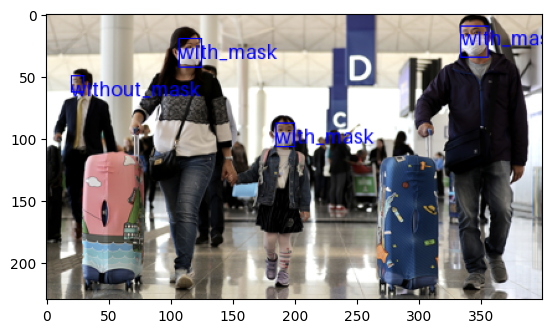

Прогноз модели: maksssksksss320.png


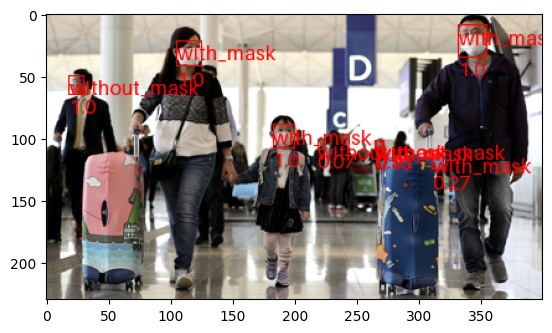

In [ ]:
# Визуализируем целевое изображение и прогноз модели на выбранном изображении
img_name = os.listdir("data/images/val/")[75]
print('Целевое изображение:', img_name)

# Определяем индекс нашего изображения в списке прогнозов модели
ind = ind_img.index(img_name.split('.')[0])

# Задаем путь к изображению из тестовой выборки
img_path = f'data/images/val/{ind_img[ind]}.png'

# подготавливаем изображение
image=Image.open(img_path)

# Создаем объект Draw из нашего изображения для отображения на нем 
# ограничительных рамок (изображение отрисовывается в 4ой координатной четверти)
plotted_image = ImageDraw.Draw(image)

# получаем координаты для всех ограничительных рамок текущего изображения
bbox = f_rcnn_target_ls[ind]['boxes'].clone().cpu().numpy()

# В цикле перебираем все аннотации
for i, box in enumerate(bbox):
    
    # Получаем параметры текущей аннотации
    x0, y0, x1, y1 = box
       
    # Отрисовываем на объекте Draw ограничительную рамку
    plotted_image.rectangle(((int(box[0]),int(box[1])), (int(box[2]),int(box[3]))),
                            outline="blue"
                            )
    
    # Добавляем метку класса
    lbl = labels_dict[f_rcnn_target_ls[ind]["labels"][i].item()]
    
    plotted_image.text(xy=(x0, y0), # координаты метки 
                        text=lbl, # метка класса и
                        fill='blue',# цвет текста
                        font=ImageFont.load_default(size=16) # размер шрифта                     
                        )

# Преобразовываем массив в изображение и выводим его на экран
plt.imshow(np.array(image))
plt.show()

# Выводим результат прогноза модели
print('Прогноз модели:', img_name)

# подготавливаем изображение
image=Image.open(img_path)

# Создаем объект Draw из нашего изображения для отображения на нем 
# ограничительных рамок (изображение отрисовывается в 4ой координатной четверти)
plotted_image = ImageDraw.Draw(image)

# получаем координаты для всех ограничительных рамок текущего изображения
bbox = f_rcnn_preds[ind]['boxes'].clone().cpu().numpy()

# В цикле перебираем все аннотации
for i, box in enumerate(bbox):
    
    # Получаем параметры текущей аннотации
    x0, y0, x1, y1 = box
      
    # Отрисовываем на объекте Draw ограничительную рамку
    plotted_image.rectangle(((int(box[0]),int(box[1])), (int(box[2]),int(box[3]))),
                            outline="red"
                            )
    
    # Добавляем метку класса и уверенность модели в этой метке
    lbl = labels_dict[f_rcnn_preds[ind]["labels"][i].item()]
    scr = str(round(f_rcnn_preds[ind]['scores'][i].item(), 2)) 
    plotted_image.text(xy=(x0, y0), # координаты метки 
                        text=lbl, # метка класса
                        fill='red',# цвет текста
                        font=ImageFont.load_default(size=16) # размер шрифта                     
                        )
    
    plotted_image.text(xy=(x0, y1), # координаты метки 
                        text=scr, # уверенность моели
                        fill='red',# цвет текста
                        font=ImageFont.load_default(size=16) # размер шрифта                     
                        )

# Преобразовываем массив в изображение и выводим его на экран
plt.imshow(np.array(image))
plt.show()

# освобождаем ресурсы памяти
plt.close()

Визуально модель достаточно точно определила координаты истинных ограничительных рамок. Предсказанные классы также соответствуют аннотации. Однако присутствует множество лишних прогнозов с низкой уверенностью.

In [ ]:
# Создадим списки тензоров с прогнозами модели и истинными ответами для валидационной выборки
preds = [i['boxes'] for i in f_rcnn_preds]
targets = [i['boxes'] for i in f_rcnn_target_ls]


# Создадим список для сбора метрики IoU 
iou_ls = []

# Создадим цикл равный длине списка с истинными ответами/прогнозами модели
for i in list(range(len(targets))):
         
    # Извлечем тензор с координатами предсказанных и истинных координат ограничительных 
    # рамок для текущего изображения из валидационной выборки
    pred = preds[i]
    target = targets[i]
    
    # Вычислим метрику IoU и перенесем тензор на ЦПУ для дальнейшего преобразования в массив numpy
    metric_iou = torchvision.ops.box_iou(pred, target).to('cpu')
   
    # В результате мы получим двумерный тензор, где в столбцах будут истинные ответы, 
    # а в строках наши прогнозы. На пересечение значение метрики. Выполняем проверку - если прогнозов 
    # модели больше или столько же сколько истинных ответов, то преобразуем тензор в массив numpy и 
    # находим максимальное значение метрики для каждой строки - прогноза модели (чтобы учесть лишние 
    # прогнозы модели в метрике как ложные). Если прогнозов модели будет меньше чем истинных ответов,
    # то выполняем поиск максимума для каждого столбца - истинного ответа (чтобы учесть в метрики 
    # пропущенные моделью объекты)
    if metric_iou.size()[0] >= metric_iou.size()[1]:
        max_values = np.max(metric_iou.numpy(), axis=1)
        
    else:
        max_values = np.max(metric_iou.numpy(), axis=0)

    # И добавляем к списку метрик значения IoU для текущего изображения
    iou_ls.extend(max_values)

# Рассчитываем и выводим среднее значение метрики IoU для валидационной выборки
metric_iou = round(np.mean(iou_ls), 2)
print('Среднее значение метрики IoU для валидационной выборки: ', metric_iou)

Среднее значение метрики IoU для валидационной выборки:  0.59


Такое низкое среднее значение метрики судя по всему связано с лишними прогнозами модели, которые мы видели выше

In [ ]:
# Создаем датафрейм для сбора значений метрики iou
frcnn_df = pd.DataFrame()

# Создаем цикл длиной равной количеству изображений в валидационной выборке
for i in range(len(ind_img)):
    
    # Создаем датафрейм для сбора значений метрики iou текущего изображения
    df = pd.DataFrame()
        
    # получаем переменные для текущего изображения: координаты ограничительных 
    # рамок прогноза и истинного ответа, наименование файла, метки классов прогноза 
    # и истиного ответа, уверенность модели в прогнозе и обновляем значение счетчика 
    # исходного количества истинных ответов
    predict_boxs = f_rcnn_preds[i]['boxes']
    target_boxs = f_rcnn_target_ls[i]['boxes']
    img_name = ind_img[i]
    predict_labels = f_rcnn_preds[i]['labels']
    target_labels = f_rcnn_target_ls[i]['labels']
    conf_scores = f_rcnn_preds[i]['scores']
    
    # В цикле перебираем все истинные ответы
    for num, target_box in enumerate(target_boxs):
            
        # В цикле проходим по всем прогнозам
        for num_box in range(len(predict_boxs)):
            
            # Вычисляем координаты области пересечения ограничительных рамок текщего 
            # истинного ответа и каждого прогноза
            xmin = max([predict_boxs[num_box][0], target_box[0]])
            ymin = max([predict_boxs[num_box][1], target_box[1]])
            xmax = min([predict_boxs[num_box][2], target_box[2]])
            ymax = min([predict_boxs[num_box][3], target_box[3]])
            
            # Выполним проверку что текущий прогноз имеет пересечение с текущим истинным ответом
            if ((xmax - xmin) > 0) & ((ymax - ymin) > 0):
                
                # Если пересечение имеется считаем его площадь, площади самих ограничительных рамок и
                # площадь их объединения
                intersection = (xmax - xmin) * (ymax - ymin)
                s_pred = (predict_boxs[num_box][2] - predict_boxs[num_box][0]) * (predict_boxs[num_box][3] - predict_boxs[num_box][1])
                s_target = (target_box[2] - target_box[0]) * (target_box[3] - target_box[1])
                union = s_pred + s_target - intersection
                
                # Вычисляем метрику и преобразуем её в список
                iou = intersection / union
                iou = iou.cpu().tolist()
            
            # Иначе значение метрики IoU будет равно 0 
            else:
                iou = 0
            
            # Собираем результаты для текущего прогноза и истинного ответа в вспомогательный датафрейм
            df_row = pd.DataFrame(data = {'filename':[img_name],
                                          'num_predict':[num_box],
                                          'num_target':[num],
                                          'predict_box':[predict_boxs[num_box].cpu().tolist()],
                                          'target_box':[target_box.cpu().tolist()],
                                          'target_label':[target_labels[num].cpu().tolist()],
                                          'predict_label':[predict_labels[num_box].cpu().tolist()],
                                          'conf_score':[conf_scores[num_box].cpu().tolist()],
                                          'iou':[iou]
                                          }
                                  )
            
            # Добавляем его к датафрейму текущего изображения
            df = pd.concat([df, df_row], axis=0, ignore_index=True)

    # С помощью сортировки получаем максимальное значение метрики для каждого истинного ответа на текущем изображении
    df = df.sort_values(['num_target', 'iou'], ascending=[True, False]).drop_duplicates('num_target')
    
    # Если существует истинный ответ со значением метрики 0, значит модель его не обнаружила (FN). 
    # Присвоим таким ответам значение метрики 200 для дальнейшей отработки
    df.loc[df['iou'] == 0, 'iou'] = 200
    

    # Обработаем случая когда прогноз является ложно положительным, т.е. прогнозов больше чем истинных ответов. 
    # Сравниваем количество оставшихся в датафрейме прогнозов с их исходным количеством
    if df['num_predict'].nunique() < len(predict_boxs):
        
        # Если прогнозов осталось меньше, то находим недостающий номер прогноза             
        for num_predict in range(len(predict_boxs)):
            if num_predict not in df['num_predict'].unique():
                
                # Формируем и добавляем строку в датафрейм со значением метрики 100 для дальнейшей обработки 
                df_row = pd.DataFrame(data = {'filename':[img_name],
                                              'num_predict':[num_predict],
                                              'num_target':['no'],
                                              'predict_box':[predict_boxs[num_predict].cpu().tolist()],
                                              'target_box':['no'],
                                              'target_label':['no'],
                                              'predict_label':[predict_labels[num_predict].cpu().tolist()],
                                              'conf_score':[conf_scores[num_predict].cpu().tolist()],
                                              'iou':[100]
                                              }
                                      )
                
                # и добавляем её к датафрейму
                df = pd.concat([df, df_row], axis=0, ignore_index=True)
    
    # Добавляем полученный для текущего изображения датафрейм к результирующему датафрейму
    frcnn_df = pd.concat([frcnn_df, df], axis=0)

# Проверяем результат    
display('frcnn_df', frcnn_df.head())

'frcnn_df'

filename  num_predict num_target  \
1   maksssksksss45            1          0   
2   maksssksksss45            0          1   
4   maksssksksss45            0          2   
2  maksssksksss812            2          0   
3  maksssksksss812            0          1   

                                         predict_box  \
1  [63.798274993896484, 33.9017333984375, 92.4617...   
2  [220.48336791992188, 36.757144927978516, 269.7...   
4  [220.48336791992188, 36.757144927978516, 269.7...   
2  [291.8699035644531, 52.59595489501953, 349.948...   
3  [163.2144775390625, 117.15916442871094, 212.34...   

                                          target_box target_label  \
1  [62.99999952316284, 34.00000071525574, 94.9999...            3   
2  [222.00000286102295, 39.99999985098839, 272.00...            2   
4  [250.0, 159.0000057220459, 278.99999618530273,...            3   
2  [291.00000858306885, 54.00000214576721, 351.99...            2   
3  [164.9999976158142, 114.99999761581421, 213.00...            2   

   predict_label  conf_score         iou  
1              3    0.993798    0.860285  
2              2    0.997662    0.847899  
4              2    0.997662  200.000000  
2              2    0.997513    0.927086  
3              2    0.998653    0.877979

In [ ]:
# Задаем списки для сбора метрик и порог IoU
precision_ls = []
recall_ls = []
tresh_iou = 0.5

# В цикле перебираем пороговые значения уверенности модели
for tresh_conf in np.linspace(0.0, 0.9, 10):
    
    # Задаем переменные для подсчета оценок
    tp = 0
    fp = 0
    fn = 0
    
    # В цикле перебираем строки результирующего датафрейма
    for row in frcnn_df.iterrows():
        
        # Если метрика IoU имеет значение 100, значит этот прогноз не соответствует ни одному
        # истинному ответу из аннотаций (например, прогнозов больше чем ответов), т.е. является
        # ложно положительным
        if row[1]['iou'] == 100:
            
            # Если увереность модели выше текущего порога, считаем ответ ложноположительным
            if (row[1]['conf_score'] >= tresh_conf):
                fp += 1
        
        # Если метрика IoU равна 200, значит этому истинному ответу не нашлось ни одного прогноза 
        # с хоть каким-нибудь пересечением ограничительной рамки (например, ответов больше прогнозов), 
        # т.е. это ложно отрицательный случай     
        elif row[1]['iou'] == 200:
            fn += 1
  
        # Если значение метрики IoU больше или равно заданному порогу, класс предсказан верно и уверенность модели больше или равна порогу,
        # то это верный положительный прогноз          
        elif ((row[1]['iou'] >= tresh_iou) and (row[1]['target_label'] == row[1]['predict_label']) and (row[1]['conf_score'] >= tresh_conf)):
            tp += 1
         
        # Если значение метрики IoU больше или равно заданному порогу, но при этом класс неправильный или если значение метрики IoU меньше 
        # порога (т.е. считаем что пересечение с рамкой истинного ответа недостаточно/отсутствует) считаем ответ ложно положительным
        elif ((row[1]['iou'] >= tresh_iou) and (row[1]['target_label'] != row[1]['predict_label']) and (row[1]['conf_score'] >= tresh_conf)) \
            or ((row[1]['iou'] < tresh_iou) and (row[1]['conf_score'] >= tresh_conf)):              
            fp +=1
        
        # Если уверенность модели ниже порога при правильном ответе считаем ответ ложноотрицательным
        elif ((row[1]['iou'] >= tresh_iou) and (row[1]['target_label'] == row[1]['predict_label']) and (row[1]['conf_score'] < tresh_conf)):
            fn += 1

    # Добавляем в соответствующие списки рассчитанные значения метрик
    precision_ls.append(tp / (tp + fp) if (tp + fp) > 0 else 0)
    recall_ls.append(tp / (tp + fn) if (tp + fn) > 0 else 0)

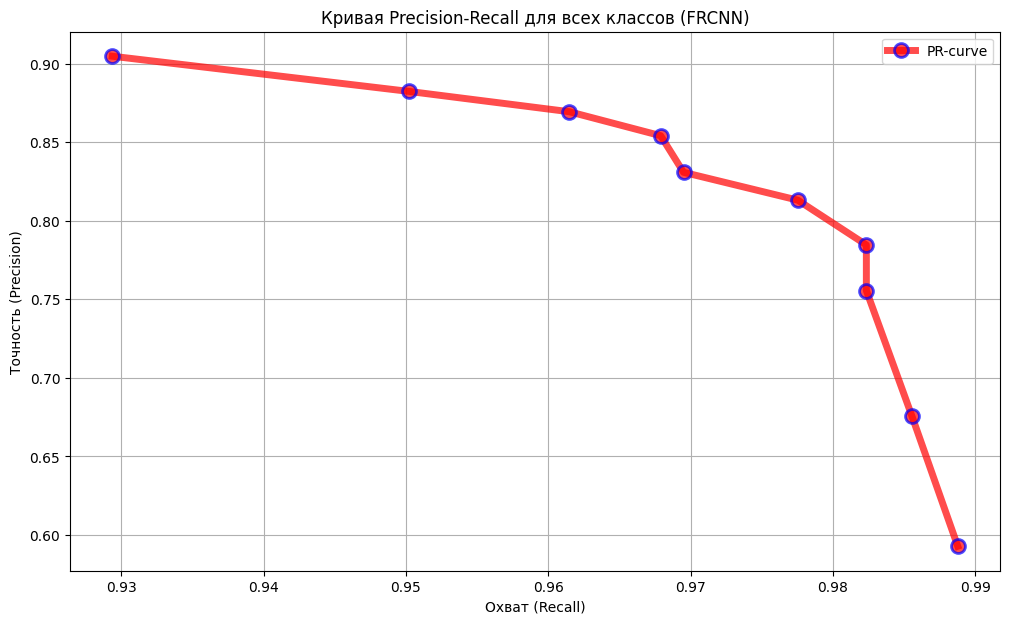

In [ ]:
# Создаем фигуру
plt.figure(figsize=(12, 7))

# Отображаем PR кривую        
plt.plot(recall_ls, precision_ls, 'o-r', alpha=0.7, label="PR-curve", lw=5, mec='b', mew=2, ms=10)

# Настраиваем отображение
plt.xlabel('Охват (Recall)')    
plt.ylabel('Точность (Precision)')
plt.title('Кривая Precision-Recall для всех классов (FRCNN)')    
plt.legend()
plt.grid(True)


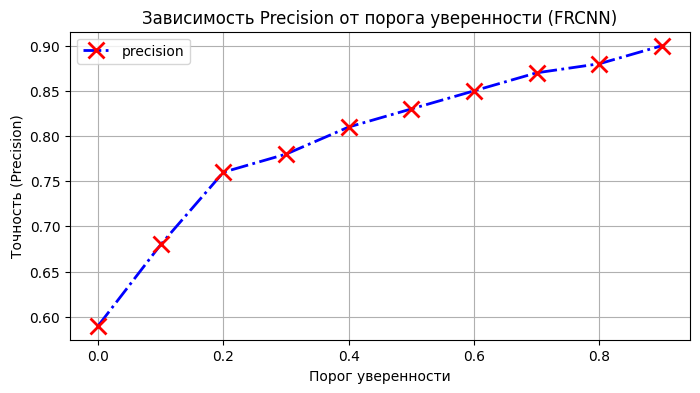

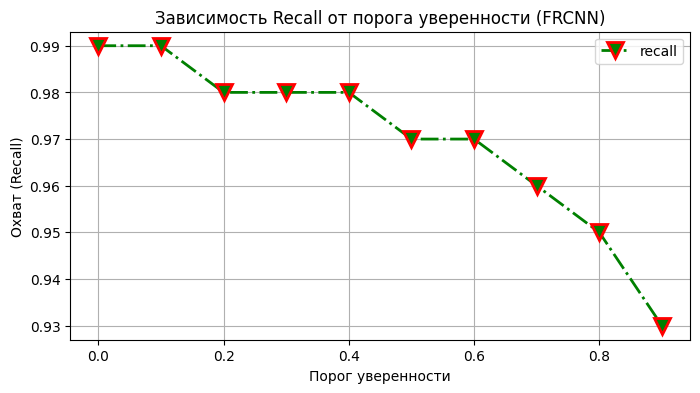

In [ ]:
# Построим графики изменения Precision и Recall при различных порогах уверенности
# Создаем фигуру
plt.figure(figsize=(8, 4))

# Строим кривую зависимости точности от порога уверенности модели
plt.plot(np.linspace(0.0, 0.9, 10), np.round(precision_ls, 2), 'x-.b', label="precision", mec='r', lw=2, mew=2, ms=12)

# Настраиваем отображение
plt.xlabel('Порог уверенности')    
plt.ylabel('Точность (Precision)')
plt.title('Зависимость Precision от порога уверенности (FRCNN)')
plt.legend()
plt.grid(True)

# Создаем фигуру
plt.figure(figsize=(8, 4))

# Строим кривую зависисмости охвата от порога уверенности модели
plt.plot(np.linspace(0.0, 0.9, 10), np.round(recall_ls, 2), 'v-.g', label="recall", mec='r', lw=2, mew=2, ms=12)

# Настраиваем отображение
plt.xlabel('Порог уверенности')    
plt.ylabel('Охват (Recall)')
plt.title('Зависимость Recall от порога уверенности (FRCNN)')
plt.legend()
plt.grid(True)

Для данной модели, судя по полученным графикам для всех классов, можно выбрать оптимальный порог уверенности 0.7. При этом Precision имеет значение около 0.87, а Recall - 0.96. Посмотрим на графики для каждого класса.

In [ ]:
# Построим PR-кривые для каждого класса
# Задаем порог IoU и словари для сбора метрик по классам
tresh_iou = 0.5
p_dict = {}
r_dict = {}

# В цикле перебираем метки классов
for i in [1, 2, 3]:
    
    # Создаем списки для сбора метрик текущего класса
    precision_ls = []
    recall_ls = []

    # В цикле перебираем пороговые значения уверенности модели
    for tresh_conf in np.linspace(0.0, 0.9, 10):
        
        # Задаем переменные для подсчета оценок
        tp = 0
        fp = 0
        fn = 0
        
        # При подсчете IoU код 100 присваивался для всех прогнозов, которые не соответствует ни одному
        # истинному ответу из аннотаций (например, прогнозов больше чем ответов), код 200 - для всех истинных 
        # ответов которым не нашлось ни одного прогноза с хоть каким-нибудь пересечением ограничительной 
        # рамки (например, ответов больше прогнозов). Фильтруем датасет по классам и увеличиваем счетчики оценок 
        # на соответствующее классу количество кодов (200 для fn) 
        fn = frcnn_df[(frcnn_df['iou']==200)&(frcnn_df['predict_label'] == i)].shape[0]
        
        # В цикле перебираем строки результирующего датафрейма отфильтрованные по текущему классу и не содержащие специальный код 200
        for row in frcnn_df[(frcnn_df['target_label']==i)&(frcnn_df['iou'] != 200)].iterrows():
            
            # Если метрика IoU имеет значение 100, значит этот прогноз не соответствует ни одному
            # истинному ответу из аннотаций (например, прогнозов больше чем ответов), т.е. является
            # ложно положительным
            if row[1]['iou'] == 100:
            
                # Если увереность модели выше текущего порога, считаем ответ ложноположительным
                if (row[1]['conf_score'] >= tresh_conf):
                    fp += 1
        
            # Если значение метрики IoU больше или равно заданному порогу, класс предсказан верно и уверенность модели больше или равна порогу,
            # то это верный положительный прогноз          
            elif ((row[1]['iou'] >= tresh_iou) and (row[1]['target_label'] == row[1]['predict_label']) and (row[1]['conf_score'] >= tresh_conf)):
                tp += 1
           
            # Если значение метрики IoU и уверенность модели больше или равны заданным порогам, но при этом класс неправильный или если значение метрики IoU меньше 
            # порога при уверенности модели большей или равной порогу считаем что пересечение с рамкой истинного ответа недостаточно/отсутствует
            elif ((row[1]['iou'] >= tresh_iou) and (row[1]['target_label'] != row[1]['predict_label']) and (row[1]['conf_score'] >= tresh_conf)) \
                or ((row[1]['iou'] < tresh_iou) and (row[1]['conf_score'] >= tresh_conf)):              
                fp +=1
            
            # Если уверенность модели ниже порога при правильном ответе считаем ответ ложноотрицательным
            elif ((row[1]['iou'] >= tresh_iou) and (row[1]['target_label'] == row[1]['predict_label']) and (row[1]['conf_score'] < tresh_conf)):
                fn += 1
                
        # Добавляем в соответствующие списки рассчитанные значения метрик
        precision_ls.append(tp / (tp + fp) if (tp + fp) > 0 else 0)
        recall_ls.append(tp / (tp + fn) if (tp + fn) > 0 else 0)
    
    # Заносим полученные списики в словари по ключу - индексу класса
    p_dict[i] = precision_ls
    r_dict[i] = recall_ls

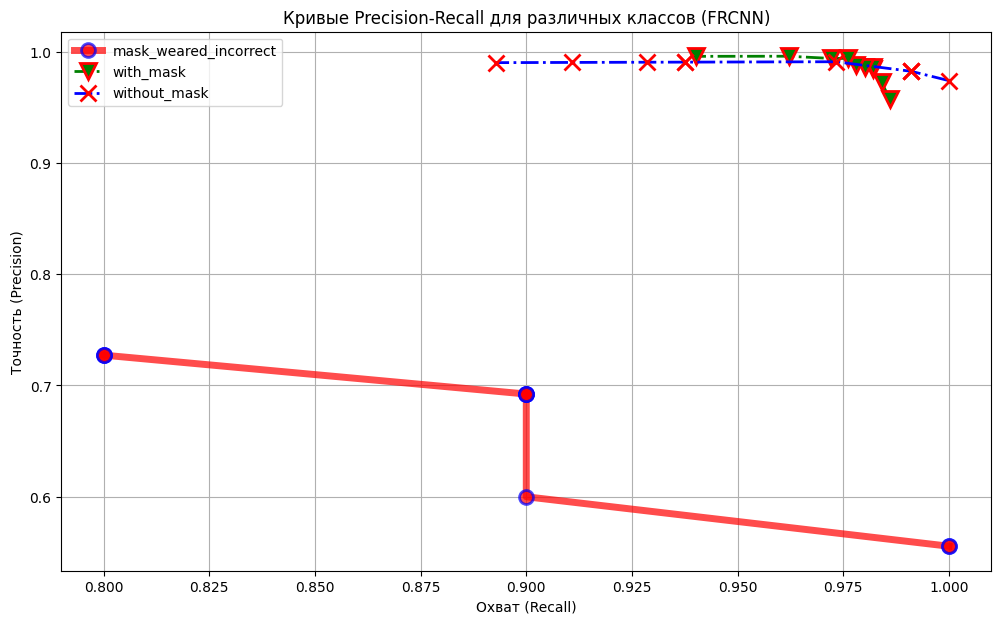

In [ ]:
# Задаем размер фигуры
plt.figure(figsize=(12, 7))

# Отображаем PR кривые для каждого класса 
plt.plot(r_dict[1], p_dict[1], 'o-r', alpha=0.7, label=class_id_to_name_mapping[0], lw=5, mec='b', mew=2, ms=10)
plt.plot(r_dict[2], p_dict[2], 'v-.g', label=class_id_to_name_mapping[1], mec='r', lw=2, mew=2, ms=12)
plt.plot(r_dict[3], p_dict[3], 'x-.b', label=class_id_to_name_mapping[2], mec='r', lw=2, mew=2, ms=12)

# Настраиваем отображение
plt.xlabel('Охват (Recall)')
plt.ylabel('Точность (Precision)')
plt.title('Кривые Precision-Recall для различных классов (FRCNN)')
plt.legend()
plt.grid(True)

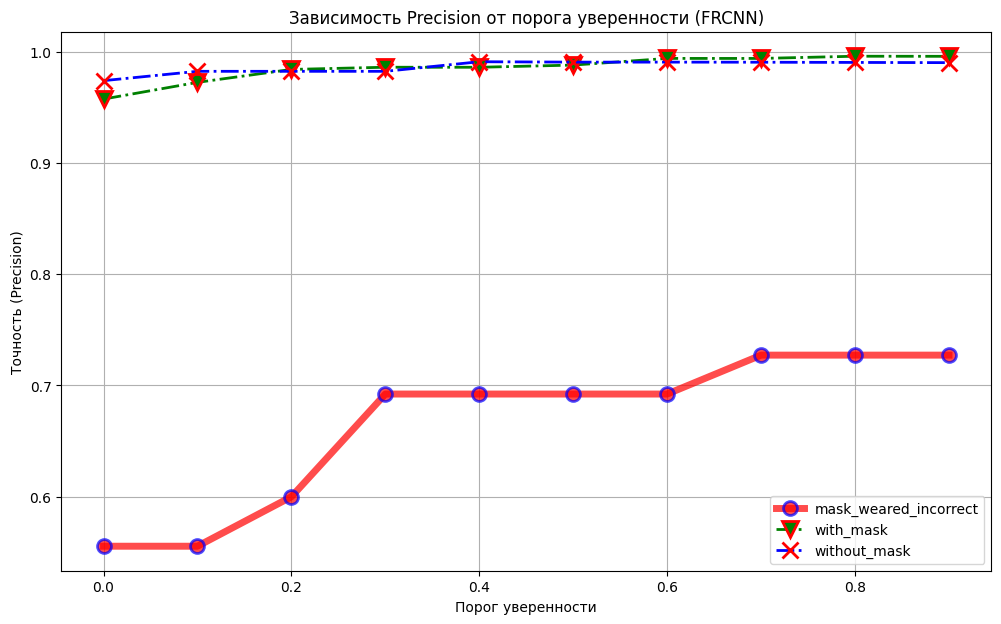

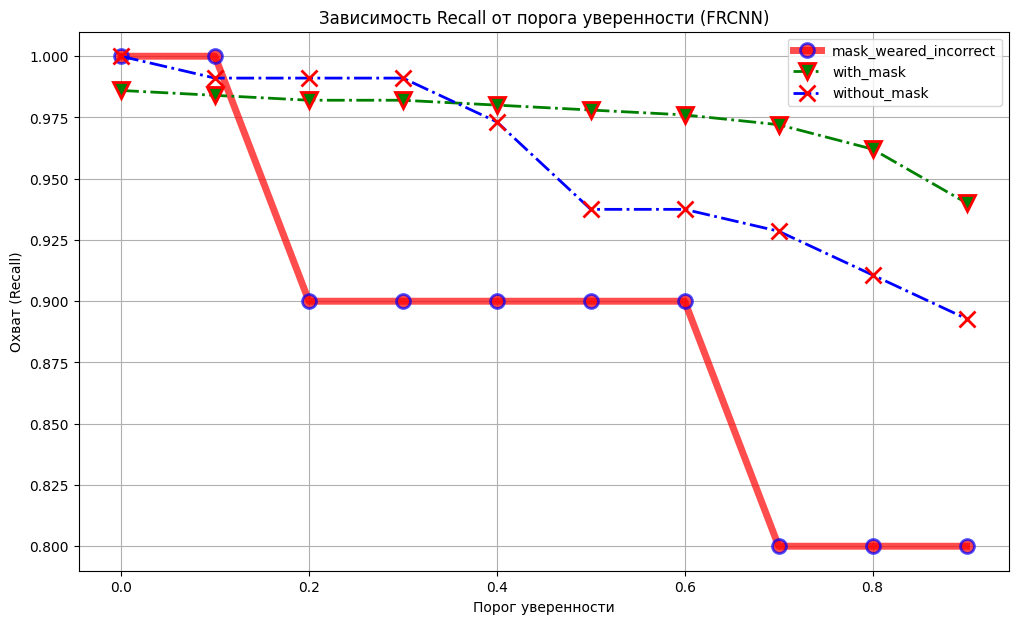

In [ ]:
# Создаем фигуру
plt.figure(figsize=(12, 7))

# Определяем метки для оси Х
x = np.linspace(0.0, 0.9, 10)

# Строим кривую зависимости точности от порога уверенности модели для каждого класса 
plt.plot(x, p_dict[1], 'o-r', alpha=0.7, label=class_id_to_name_mapping[0], lw=5, mec='b', mew=2, ms=10)
plt.plot(x, p_dict[2], 'v-.g', label=class_id_to_name_mapping[1], mec='r', lw=2, mew=2, ms=12)
plt.plot(x, p_dict[3], 'x-.b', label=class_id_to_name_mapping[2], mec='r', lw=2, mew=2, ms=12)

# Настраиваем отображение
plt.xlabel('Порог уверенности')    
plt.ylabel('Точность (Precision)')
plt.title('Зависимость Precision от порога уверенности (FRCNN)')
plt.legend()
plt.grid(True)

# Создаем фигуру
plt.figure(figsize=(12, 7))

# Строим кривую зависисмости охвата от порога уверенности для каждого класса 
plt.plot(x, r_dict[1], 'o-r', alpha=0.7, label=class_id_to_name_mapping[0], lw=5, mec='b', mew=2, ms=10)
plt.plot(x, r_dict[2], 'v-.g', label=class_id_to_name_mapping[1], mec='r', lw=2, mew=2, ms=12)
plt.plot(x, r_dict[3], 'x-.b', label=class_id_to_name_mapping[2], mec='r', lw=2, mew=2, ms=12)

# Настраиваем отображение
plt.xlabel('Порог уверенности')    
plt.ylabel('Охват (Recall)')
plt.title('Зависимость Recall от порога уверенности (FRCNN)')
plt.legend()
plt.grid(True)

Здесь также видно что минорного класса графики сильно отбиваются от основной группы. Для достаточно хорошей работы модели на всех классах можно предложить порог уверенности 0.6. При этом минимальное значение Precision каждого класса не ниже 0.69, а Recall - 0.9.

In [56]:
# Сформируем словарь с результатами
result_dict = {'model': ['fasterrcnn_resnet50_fpn_v2'],
               'parameters': [43712278],
               'GFLOPs': [280.37],
               'train_time, s': [np.round(np.sum(epoch_time), 2)],
               'time_per_epoch, s': [np.round(np.mean(epoch_time))],
               'mAP_50': [0.89],
               'mAP_50_95': [0.56],
               'iou':[0.59]
               }

# Преобразуем его в датафрейм и отобразим результат
df = pd.DataFrame(data=result_dict)
display(df)

# Дозапишем результат в файл
df.to_csv('results_df.csv', index=False, header=False, mode='a')


model  parameters  GFLOPs  train_time, s  \
0  fasterrcnn_resnet50_fpn_v2    43712278  280.37        7852.78   

   time_per_epoch, s  mAP_50  mAP_50_95   iou  
0              157.0    0.89       0.56  0.59

In [57]:
# Выведем результаты для сравнения
df = pd.read_csv('results_df.csv')
display(df)

model  parameters  GFLOPs  train_time, s  \
0                   YOLO v11m    20032345   67.70         790.00   
1  fasterrcnn_resnet50_fpn_v2    43712278  280.37        7852.78   

   time_per_epoch, s  mAP_50  mAP_50_95   iou  
0               16.0    0.89       0.65  0.77  
1              157.0    0.89       0.56  0.59

# Выводы

* Модель YOLOv11m имеет примерно вдвое меньше параметров и почти на порядок быстрее по времени обучения чем fasterrrcnn_resnet50_fpn_v2. 
* По метрике mAP_50 обе модели показали схожий результат 89%, а по метрике mAP_50_95 YOLOv11m превосходит fasterrrcnn_resnet50_fpn_v2 (65% против 56%).
* Среднее значение IoU модели fasterrrcnn_resnet50_fpn_v2 ниже чем у YOLOv11m (0.59 против 0.77). Скорее всего это связаны с большим количеством ложных срабатываний. Выбор оптимального порога уверенности может помочь исправить ситуацию.